In [1663]:
import seaborn as sns
import pandas as pd
import re
import matplotlib as mpl
from matplotlib import rc
import missingno as msno
import warnings
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')

In [1664]:
final_df = pd.read_csv(
    '../../final_df_14/final_df_14.csv', encoding="cp949").drop(columns='Unnamed: 0')
X_train = pd.read_csv(
    '../../final_df_14/X_train_14.csv').drop(columns='Unnamed: 0')
y_train = pd.read_csv(
    '../../final_df_14/y_train_14.csv').drop(columns='Unnamed: 0')
X_test = pd.read_csv(
    '../../final_df_14/X_test_14.csv').drop(columns='Unnamed: 0')
y_test = pd.read_csv(
    '../../final_df_14/y_test_14.csv').drop(columns='Unnamed: 0')

In [1665]:
# X_train.drop(columns=['aud_nationwide', 'log_aud'], inplace=True)
# X_test.drop(columns=['aud_nationwide', 'log_aud'], inplace=True)

In [1666]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 925 non-null    object 
 1   director              925 non-null    object 
 2   distributor           925 non-null    object 
 3   distributor_group     925 non-null    object 
 4   release_date          925 non-null    int64  
 5   release_season        925 non-null    object 
 6   release               925 non-null    object 
 7   form                  925 non-null    object 
 8   nation                925 non-null    object 
 9   screen                925 non-null    int64  
 10  rev_nationwide        925 non-null    float64
 11  aud_nationwide        925 non-null    int64  
 12  rev_seoul             925 non-null    int64  
 13  rev_seoul.1           925 non-null    int64  
 14  genre                 925 non-null    object 
 15  rate                  9

In [1667]:
len(X_train), len(X_test), len(y_train), len(y_test),

(740, 185, 740, 185)

In [1668]:
df = pd.concat([X_train, y_train], axis=1)

In [1669]:
len(df.columns)

35

In [1670]:
df = df.drop(columns=['distributor_group', 'release', 'form',
                      'rev_nationwide', 'rev_seoul', 'rev_seoul.1', 'director_count'])

In [1671]:
len(df.columns)

28

In [1672]:
df.columns

Index(['title', 'director', 'distributor', 'release_date', 'release_season',
       'nation', 'screen', 'genre', 'rate', 'type', 'expert_rating',
       'starring_actors', 'running_times', 'audience_rating',
       'rating_audiences', 'realease_year', 'director_power', 'sequel',
       'original', 'actor_power', 'director_movie_count', 'actor_movie_count',
       'before_news', 'after_news', 'holiday', 'dist_cat', 'aud_nationwide',
       'log_aud'],
      dtype='object')

# 흐름
- screen, expert_rating, audience_rating, running_times, sequel, original, nation,  genre, rate, dist_cat
- actor_power, director_power
- before_news, after_news
- rating_audiences
- holiday
- 종속변수 로그
- 잔차 비선형성 제거
- 아웃라이어 제거
- news 피쳐의 변형


# model1
- 참고 논문들에서 사용한 독립변수들 사용
- 10개 피쳐들 단순 적용
    - screen, expert_rating, audience_rating, running_times, sequel, original, nation,  genre, rate, dist_cat


In [2016]:
test_rsquare_dict = {}
kfold_dict_learn = {}
kfold_dict = {}
kfold_dict_avr = []
RMSE_dict = {}
result_rsquare = {}
result_adj_rsquare = {}
kfold_df = pd.DataFrame()

In [2017]:
df1 = df.copy()

In [2018]:
# 10개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model1 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     45.92
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          6.80e-142
Time:                        14:52:06   Log-Likelihood:                -11405.
No. Observations:                 740   AIC:                         2.287e+04
Df Residuals:                     710   BIC:                         2.301e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.57

In [2019]:
# kfold 1

from sklearn.model_selection import KFold

kfold_dict_learn['1'] = []
kfold_dict['1'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df1)):
    df_train = df1.iloc[idx_train]
    df_test = df1.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['1'].append(result.rsquared)
    kfold_dict['1'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['1'])/10)

학습 R2 = 0.65211451, 검증 R2 = 0.64305748
학습 R2 = 0.64854685, 검증 R2 = 0.68184139
학습 R2 = 0.64333485, 검증 R2 = 0.67402159
학습 R2 = 0.65503339, 검증 R2 = 0.60839195
학습 R2 = 0.65137804, 검증 R2 = 0.63919861
학습 R2 = 0.64319284, 검증 R2 = 0.72309674
학습 R2 = 0.65757770, 검증 R2 = 0.58053591
학습 R2 = 0.68605278, 검증 R2 = 0.36103947
학습 R2 = 0.65555049, 검증 R2 = 0.57760004
학습 R2 = 0.64081401, 검증 R2 = 0.69909107


In [2020]:
# model1의 테스트 R

pred = result1.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6063840307534749

In [2021]:
pred = result1.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['1'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1480648594999.2756
RMSE =  1216819.0477631732


In [2022]:
result_rsquare['result1_rsquared'] = result1.rsquared
result_adj_rsquare['result1_adj_rsquared'] = result1.rsquared_adj

In [2023]:
test_rsquare_dict['1'] = rsquared

# model2
- actor_power, director_power 추가

In [2024]:
df2 = df1.copy()

In [2025]:
# 12개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating',
                 'running_times', 'actor_power', 'director_power']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model2 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     45.53
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          2.76e-146
Time:                        14:52:07   Log-Likelihood:                -11390.
No. Observations:                 740   AIC:                         2.284e+04
Df Residuals:                     708   BIC:                         2.299e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.60

In [2026]:
# kfold 2

from sklearn.model_selection import KFold

kfold_dict_learn['2'] = []
kfold_dict['2'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['2'].append(result.rsquared)
    kfold_dict['2'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['2'])/10)

학습 R2 = 0.66498141, 검증 R2 = 0.66241464
학습 R2 = 0.66401365, 검증 R2 = 0.67229819
학습 R2 = 0.65411530, 검증 R2 = 0.70154754
학습 R2 = 0.66651418, 검증 R2 = 0.65086356
학습 R2 = 0.66730639, 검증 R2 = 0.60629479
학습 R2 = 0.65840796, 검증 R2 = 0.71739871
학습 R2 = 0.67264766, 검증 R2 = 0.57948672
학습 R2 = 0.69427664, 검증 R2 = 0.41135605
학습 R2 = 0.66997354, 검증 R2 = 0.58403934
학습 R2 = 0.66030769, 검증 R2 = 0.67135977


In [2027]:
# model2의 테스트 R

pred = result2.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6243355959961607

In [2028]:
test_rsquare_dict['2'] = rsquared

In [2029]:
pred = result2.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['2'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1413120948939.841
RMSE =  1188747.638878766


In [2030]:
result_rsquare['result2_rsquared'] = result2.rsquared
result_adj_rsquare['result2_adj_rsquared'] = result2.rsquared_adj

# model3
- before_news, after_news 추가

In [2031]:
df3 = df2.copy()

In [2032]:
# 14개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model3 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     47.53
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          1.20e-155
Time:                        14:52:09   Log-Likelihood:                -11363.
No. Observations:                 740   AIC:                         2.279e+04
Df Residuals:                     706   BIC:                         2.295e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.28

In [2033]:
# kfold 3

from sklearn.model_selection import KFold

kfold_dict_learn['3'] = []
kfold_dict['3'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['3'].append(result.rsquared)
    kfold_dict['3'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['3'])/10)

학습 R2 = 0.68853920, 검증 R2 = 0.68673027
학습 R2 = 0.68284680, 검증 R2 = 0.76228227
학습 R2 = 0.68020463, 검증 R2 = 0.71321405
학습 R2 = 0.69279813, 검증 R2 = 0.64056900
학습 R2 = 0.69104915, 검증 R2 = 0.62879596
학습 R2 = 0.68664015, 검증 R2 = 0.68585173
학습 R2 = 0.68940175, 검증 R2 = 0.66769567
학습 R2 = 0.72118241, 검증 R2 = 0.40690405
학습 R2 = 0.69552578, 검증 R2 = 0.57533130
학습 R2 = 0.68324363, 검증 R2 = 0.69996448


In [2034]:
# model3의 테스트 R

pred = result3.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6445087799148355

In [2035]:
test_rsquare_dict['3'] = rsquared

In [2036]:
pred = result3.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['3'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1337236333579.7866
RMSE =  1156389.3520695297


In [2037]:
result_rsquare['result3_rsquared'] = result3.rsquared
result_adj_rsquare['result3_adj_rsquared'] = result3.rsquared_adj

# model4
- rating_audiences 추가 

In [2038]:
df4 = df3.copy()

In [2039]:
# 15개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model4 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     59.93
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          3.69e-183
Time:                        14:52:11   Log-Likelihood:                -11293.
No. Observations:                 740   AIC:                         2.266e+04
Df Residuals:                     705   BIC:                         2.282e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                9

In [2040]:
# kfold 4

from sklearn.model_selection import KFold

kfold_dict_learn['4'] = []
kfold_dict['4'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df4)):
    df_train = df4.iloc[idx_train]
    df_test = df4.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['4'].append(result.rsquared)
    kfold_dict['4'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['4'])/10)

학습 R2 = 0.74325552, 검증 R2 = 0.73025309
학습 R2 = 0.73678227, 검증 R2 = 0.81312361
학습 R2 = 0.75912834, 검증 R2 = 0.49906999
학습 R2 = 0.74333416, 검증 R2 = 0.73092590
학습 R2 = 0.74130819, 검증 R2 = 0.75381165
학습 R2 = 0.73567343, 검증 R2 = 0.79679714
학습 R2 = 0.73169839, 검증 R2 = 0.84482117
학습 R2 = 0.77969845, 검증 R2 = 0.42026655
학습 R2 = 0.74538901, 검증 R2 = 0.68728025
학습 R2 = 0.73899896, 검증 R2 = 0.74426151


In [2041]:
# model4의 테스트 R

pred = result4.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7048007034475638

In [2042]:
test_rsquare_dict['4'] = rsquared

In [2043]:
pred = result4.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['4'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1110438746989.4246
RMSE =  1053773.5748202384


In [2044]:
result_rsquare['result4_rsquared'] = result4.rsquared
result_adj_rsquare['result4_adj_rsquared'] = result4.rsquared_adj

# model5
- holiday 추가

In [2045]:
df5 = df4.copy()

In [2046]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model5 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df5)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     58.48
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          6.53e-183
Time:                        14:52:13   Log-Likelihood:                -11292.
No. Observations:                 740   AIC:                         2.266e+04
Df Residuals:                     704   BIC:                         2.282e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [2047]:
# kfold 5

from sklearn.model_selection import KFold

kfold_dict_learn['5'] = []
kfold_dict['5'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df5)):
    df_train = df5.iloc[idx_train]
    df_test = df5.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['5'].append(result.rsquared)
    kfold_dict['5'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['5'])/10)

학습 R2 = 0.74416492, 검증 R2 = 0.73278592
학습 R2 = 0.73818246, 검증 R2 = 0.80929549
학습 R2 = 0.76002685, 검증 R2 = 0.50139675
학습 R2 = 0.74447553, 검증 R2 = 0.73195975
학습 R2 = 0.74316616, 검증 R2 = 0.73400369
학습 R2 = 0.73745404, 검증 R2 = 0.78923608
학습 R2 = 0.73249659, 검증 R2 = 0.84936533
학습 R2 = 0.78050370, 검증 R2 = 0.42367878
학습 R2 = 0.74670011, 검증 R2 = 0.68496689
학습 R2 = 0.73951747, 검증 R2 = 0.74795337


In [2048]:
# model5의 테스트 R

pred = result5.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6990985325678982

In [2049]:
test_rsquare_dict['5'] = rsquared

In [2050]:
pred = result5.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['5'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1131888362759.8018
RMSE =  1063902.4216345227


In [2051]:
result_rsquare['result5_rsquared'] = result5.rsquared
result_adj_rsquare['result5_adj_rsquared'] = result5.rsquared_adj

# model6
- 종속변수에 log

In [2052]:
df6 = df5.copy()

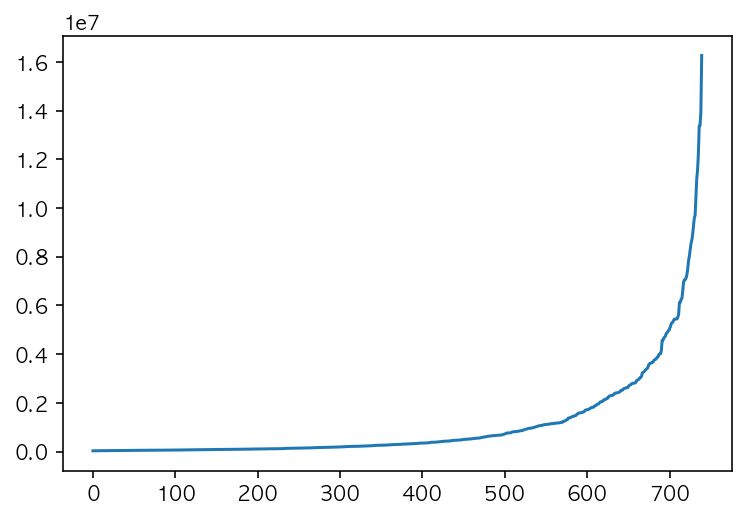

In [2053]:
plt.plot(df6['aud_nationwide'].sort_values().reset_index(drop=True))

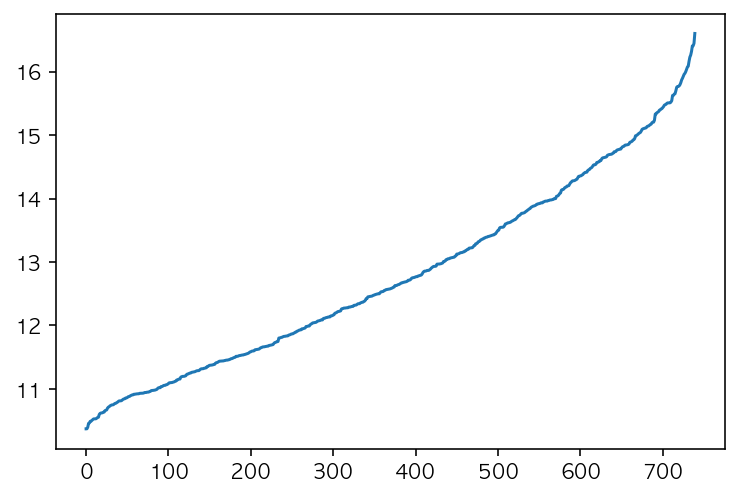

In [2054]:
plt.plot(np.log(df6['aud_nationwide'].sort_values().reset_index(drop=True)))

In [2055]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model6 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df6)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     73.10
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          1.25e-208
Time:                        14:52:16   Log-Likelihood:                -780.17
No. Observations:                 740   AIC:                             1632.
Df Residuals:                     704   BIC:                             1798.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [2056]:
# kfold 6

from sklearn.model_selection import KFold

kfold_dict_learn['6'] = []
kfold_dict['6'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df6)):
    df_train = df6.iloc[idx_train]
    df_test = df6.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['6'].append(result.rsquared)
    kfold_dict['6'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['6'])/10)

학습 R2 = 0.78204344, 검증 R2 = 0.79079385
학습 R2 = 0.78587245, 검증 R2 = 0.74442310
학습 R2 = 0.78089355, 검증 R2 = 0.69765359
학습 R2 = 0.79094868, 검증 R2 = 0.71034140
학습 R2 = 0.78322373, 검증 R2 = 0.78212960
학습 R2 = 0.78699304, 검증 R2 = 0.73778184
학습 R2 = 0.78793671, 검증 R2 = 0.72369768
학습 R2 = 0.78691007, 검증 R2 = 0.74555826
학습 R2 = 0.78383108, 검증 R2 = 0.77178975
학습 R2 = 0.78948926, 검증 R2 = 0.72675976


In [2057]:
# model6의 테스트 R

pred = result6.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7439545187829599

In [2058]:
test_rsquare_dict['6'] = rsquared

In [2059]:
pred = result6.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['6'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243532563.353
RMSE =  2195960.731106855


In [2060]:
result_rsquare['result6_rsquared'] = result6.rsquared
result_adj_rsquare['result6_adj_rsquared'] = result6.rsquared_adj

# model7
- 독립변수 잔차의 비선형성 제거
    - screen
    - rating_audiences -> 두번 적용
    - news 피쳐 처리

In [2061]:
df7 = df6.copy()

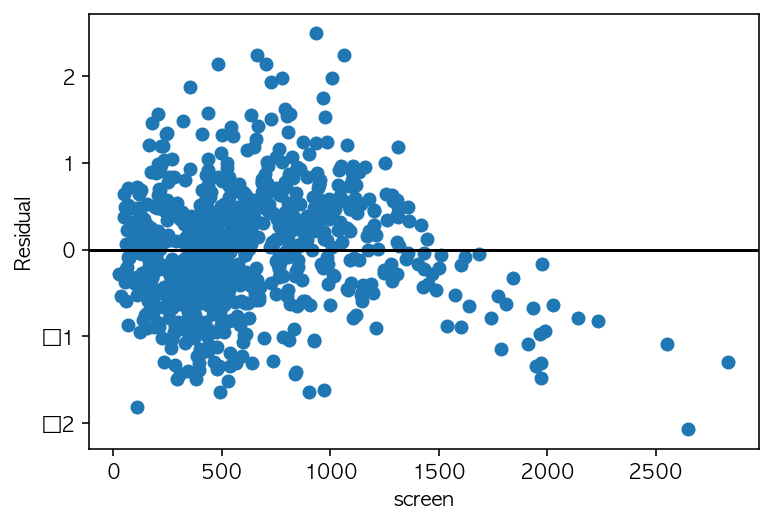

In [2062]:
plt.plot(df7['screen'], result6.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("screen")
plt.ylabel("Residual")
plt.show()

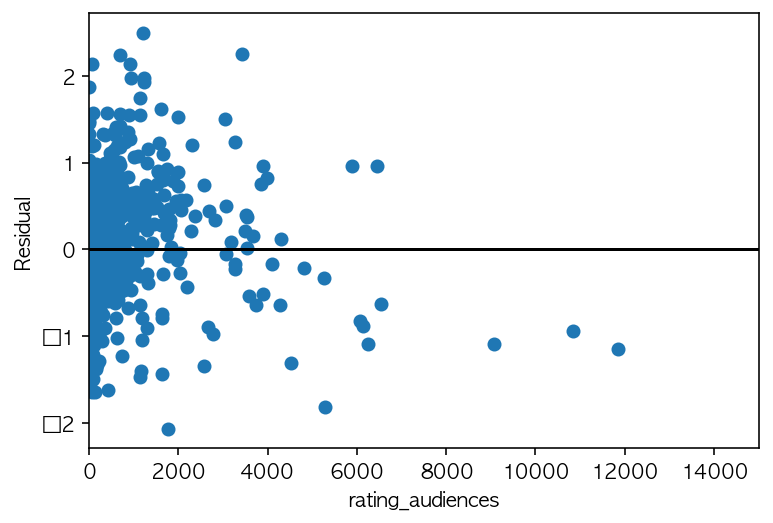

In [2063]:
plt.plot(df7['rating_audiences'], result6.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("rating_audiences")
plt.ylabel("Residual")
plt.xlim(0, 15000)
plt.show()

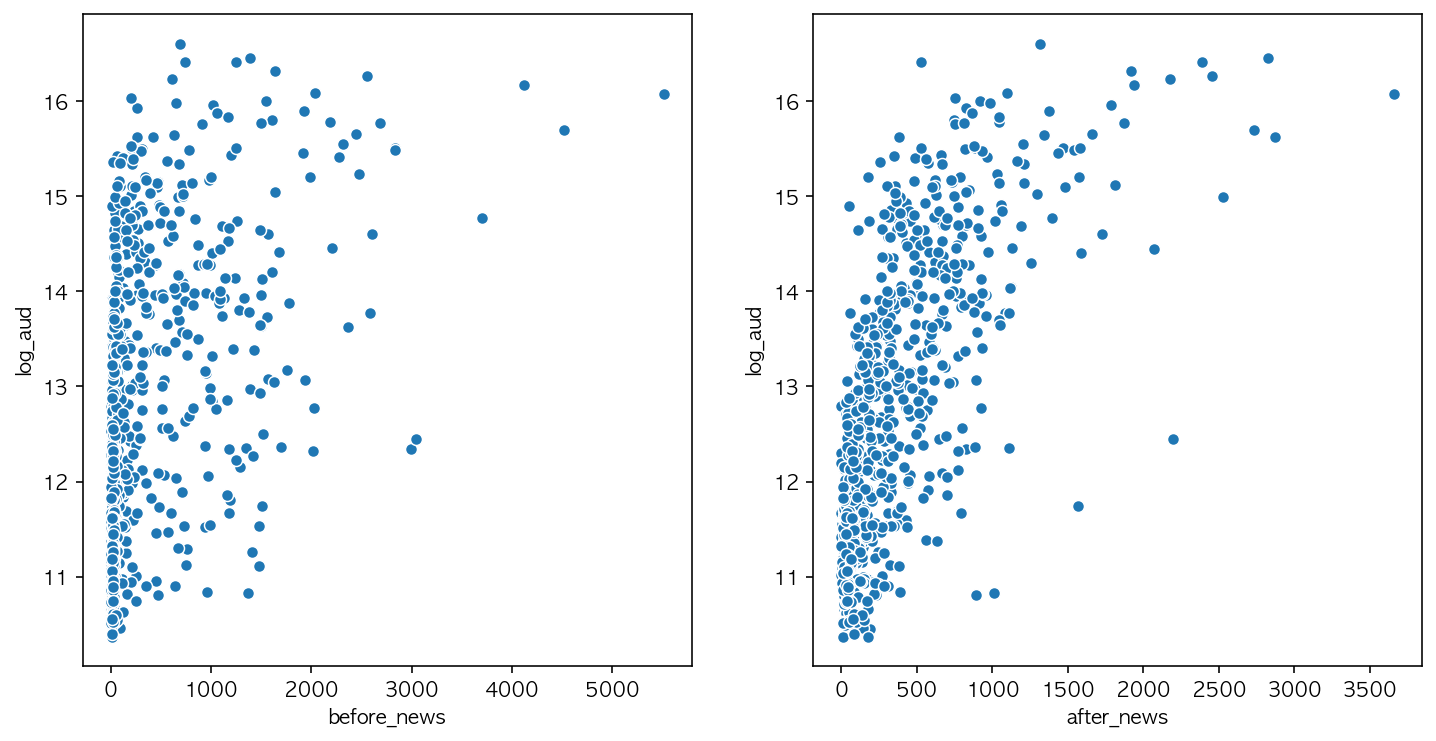

In [2064]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="before_news", y="log_aud", data=df7)
plt.subplot(122)
sns.scatterplot(x="after_news", y="log_aud", data=df7)
plt.show()

In [2065]:
df7['before_news_0to1'] = df7['before_news'].apply(
    lambda news: 1 if news == 0 else news)
df7['after_news_0to1'] = df7['after_news'].apply(
    lambda news: 1 if news == 0 else news)
df7['log_before_news'] = df7['before_news_0to1'].apply(
    lambda news: np.log(news))
df7['log_after_news'] = df7['after_news_0to1'].apply(
    lambda news: np.log(news))

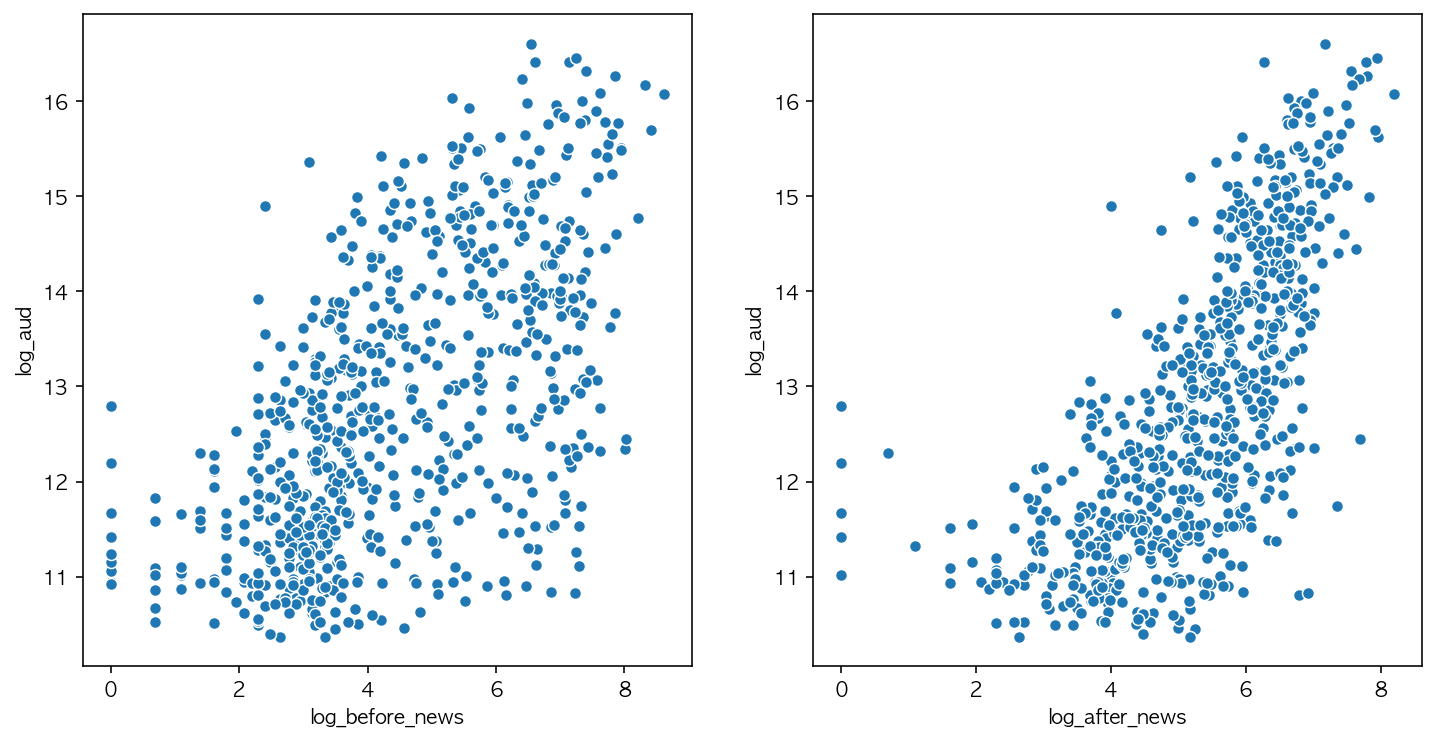

In [2066]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="log_before_news", y="log_aud", data=df7)
plt.subplot(122)
sns.scatterplot(x="log_after_news", y="log_aud", data=df7)
plt.show()

In [2067]:
'rating_audiences**(3/7)', 'rating_audiences**2'

('rating_audiences**(3/7)', 'rating_audiences**2')

In [2068]:
df7['rating_audiences_0to1'] = df7['rating_audiences'].apply(lambda rate: 1 if rate == 0 else rate)

In [2069]:
# 16개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)', 'np.log(rating_audiences_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model7 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df7)
result7 = model7.fit()
print(result7.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     86.80
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          2.43e-229
Time:                        14:52:20   Log-Likelihood:                -729.44
No. Observations:                 740   AIC:                             1531.
Df Residuals:                     704   BIC:                             1697.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [2070]:
# kfold 7

from sklearn.model_selection import KFold

kfold_dict_learn['7'] = []
kfold_dict['7'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df7)):
    df_train = df7.iloc[idx_train]
    df_test = df7.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['7'].append(result.rsquared)
    kfold_dict['7'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['7'])/10)

학습 R2 = 0.81006082, 검증 R2 = 0.81794888
학습 R2 = 0.81122614, 검증 R2 = 0.79691954
학습 R2 = 0.80660139, 검증 R2 = 0.83347783
학습 R2 = 0.81580761, 검증 R2 = 0.76859018
학습 R2 = 0.81386434, 검증 R2 = 0.77889368
학습 R2 = 0.81662427, 검증 R2 = 0.73985761
학습 R2 = 0.81696328, 검증 R2 = 0.73425426
학습 R2 = 0.81241887, 검증 R2 = 0.79393083
학습 R2 = 0.81080544, 검증 R2 = 0.80862510
학습 R2 = 0.81642726, 검증 R2 = 0.76344091


In [2071]:
X_test['before_news_0to1'] = X_test['before_news'].apply(
    lambda news: 1 if news == 0 else news)
X_test['after_news_0to1'] = X_test['after_news'].apply(
    lambda news: 1 if news == 0 else news)

In [2072]:
X_test['rating_audiences_0to1'] = X_test['rating_audiences'].apply(lambda rate: 1 if rate == 0 else rate)

In [2073]:
# model7의 테스트 R

pred = result7.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.793510820664285

In [2074]:
test_rsquare_dict['7'] = rsquared

In [2075]:
pred = result7.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['7'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243744128.961
RMSE =  2195960.7792783915


In [2076]:
result_rsquare['result7_rsquared'] = result7.rsquared
result_adj_rsquare['result7_adj_rsquared'] = result7.rsquared_adj

# model8
- 아웃라이어 제거 

In [2303]:
df8 = df7.copy()

In [2304]:
# # Cook's distance

# sm.graphics.influence_plot(result7, plot_alpha=0.3)
# plt.show()

In [2305]:
X = df8[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']]
dfy = df8['log_aud']

In [2306]:
len(X), len(y)

(740, 733)

In [2307]:
pred = result7.predict(X)

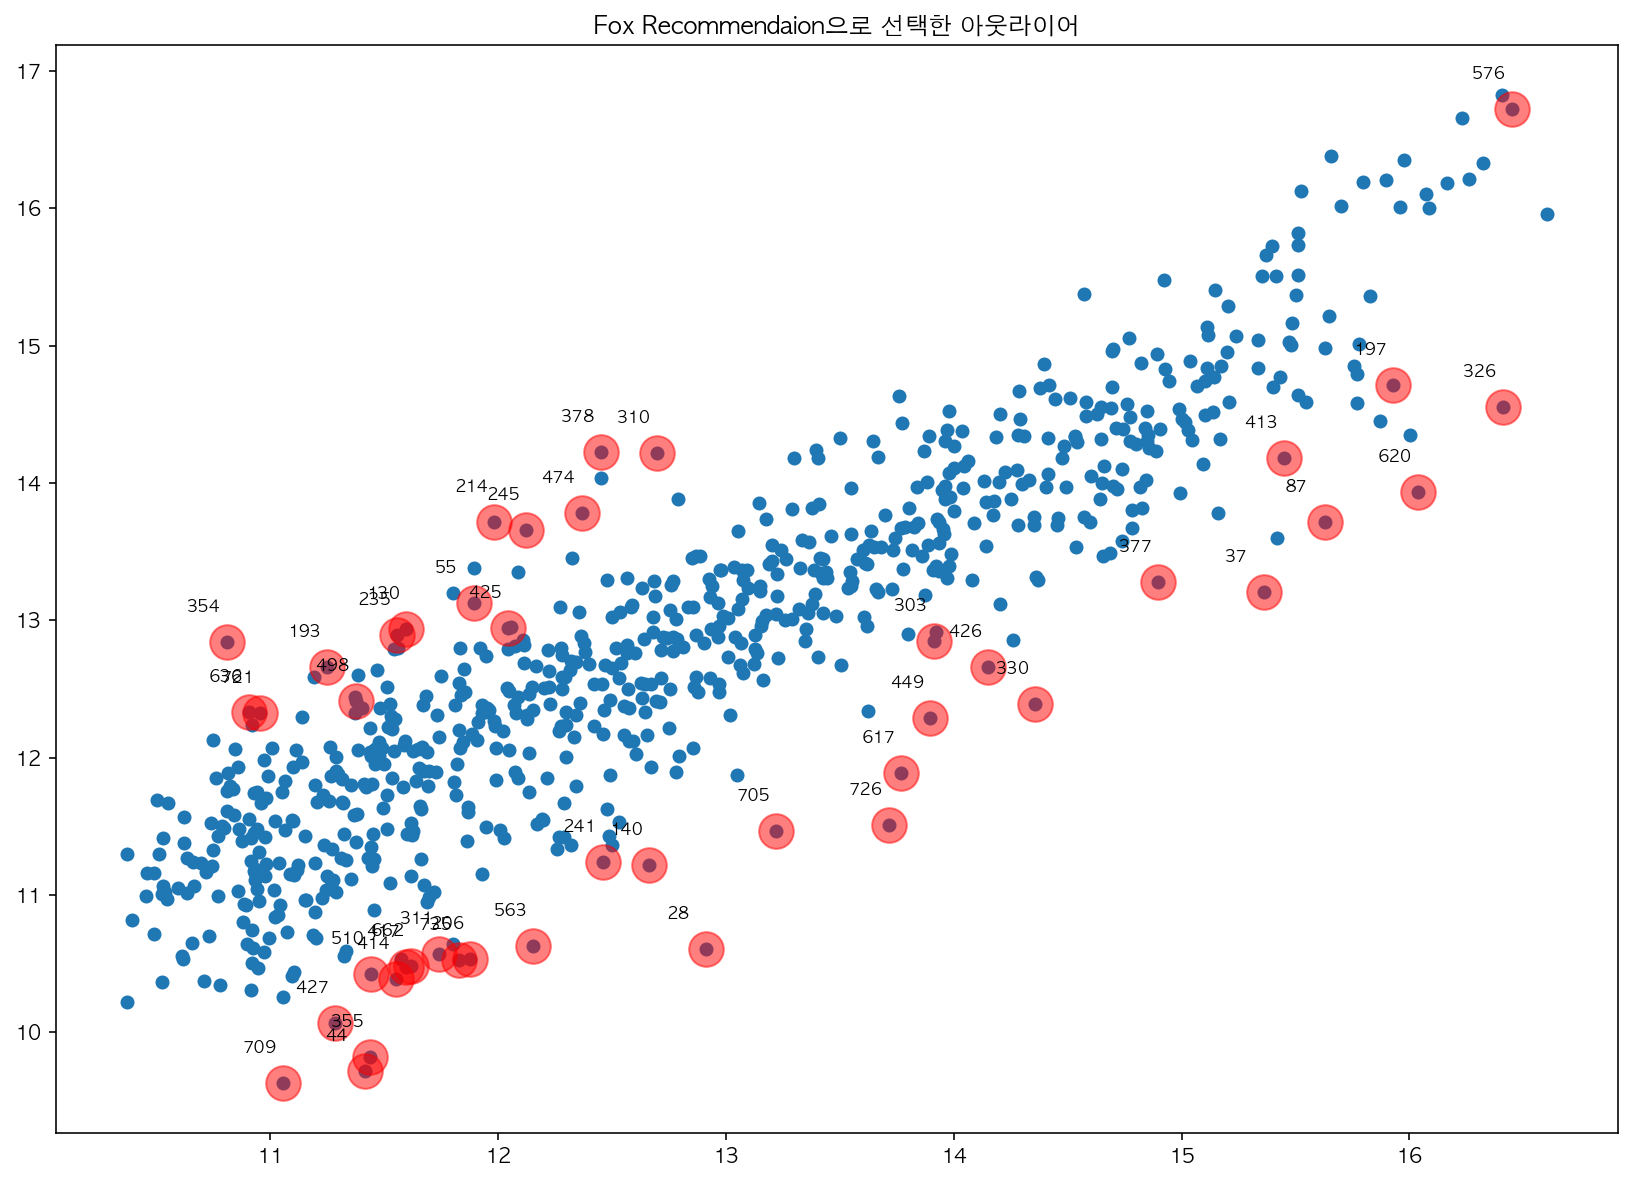

In [2308]:
from statsmodels.graphics import utils

plt.figure(figsize=(14, 10))

influence = result7.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (740 - 36 - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy[idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(dfy[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("Fox Recommendaion으로 선택한 아웃라이어")
plt.show()

In [2309]:
print(idx)

[ 28  37  44  55  87 130 140 193 197 206 214 235 241 245 303 310 311 326
 330 354 355 377 378 413 414 417 425 426 427 449 474 498 510 563 576 617
 620 636 662 705 709 721 726 735]


In [2310]:
# cooks_d2[35] > fox_cr

In [2311]:
cooks_dict = {}
for index in idx:
    cooks_dict[str(index)] = cooks_d2[index]

In [2312]:
cooks_dict = sorted(cooks_dict.items(), key=(lambda x : x[1]), reverse=True)

In [2313]:
cooks_arr = cooks_dict[:7]
cooks_arr

[('426', 0.04248506117833746),
 ('354', 0.03877428108555198),
 ('28', 0.033029845448531304),
 ('449', 0.02515432679776791),
 ('140', 0.022383851848427075),
 ('726', 0.02141719306289632),
 ('617', 0.02013130587132252)]

In [2314]:
outlier_index = []
for value in cooks_arr:
    print(value[0], df8.iloc[int(value[0])]['title'])
    outlier_index.append(int(value[0]))

426 벤허
354 옥자
28 나의 소녀시대
449 하루
140 번 더 스테이지: 더 무비
726 월요일이 사라졌다
617 님아, 그 강을 건너지 마오


In [2315]:
# from statsmodels.graphics import utils

# plt.figure(figsize=(14, 10))

# influence = result7.get_influence()
# cooks_d2, pvals = influence.cooks_distance
# fox_cr = 4 / (740 - 36 - 1)
# idx = np.where(cooks_d2 >= 0.02013130587132252)[0]

# ax = plt.subplot()
# plt.scatter(dfy, pred)
# plt.scatter(dfy[idx], pred[idx], s=300, c="r", alpha=0.5)
# utils.annotate_axes(range(len(idx)), idx,
#                     list(zip(dfy[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
# plt.title("Fox Recommendaion으로 선택한 아웃라이어")
# plt.show()

In [2316]:
# outlier_index = idx
# for index in idx:
#     print(df8.iloc[index]['title'], df8.iloc[index]['release_date'], index)

In [2317]:
# 옥자 354
# 어벤져스: 인피니티 워 361
# 벤허 426
# 어벤져스: 엔드게임 576

In [2318]:
df8 = df8.drop(index=outlier_index)

In [2319]:
# df8.iloc[576]

In [2320]:
len(df8)

733

In [2321]:
# 16개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)','np.log(rating_audiences_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model8 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df8)
result8 = model8.fit()
print(result8.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     96.72
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          2.13e-241
Time:                        15:56:08   Log-Likelihood:                -688.52
No. Observations:                 733   AIC:                             1449.
Df Residuals:                     697   BIC:                             1615.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [2322]:
# kfold 8

from sklearn.model_selection import KFold

kfold_dict_learn['8'] = []
kfold_dict['8'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df8)):
    df_train = df8.iloc[idx_train]
    df_test = df8.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['8'].append(result.rsquared)
    kfold_dict['8'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['8'])/10)

학습 R2 = 0.83388274, 검증 R2 = 0.77522263
학습 R2 = 0.82645506, 검증 R2 = 0.84588455
학습 R2 = 0.82555286, 검증 R2 = 0.84151863
학습 R2 = 0.83154740, 검증 R2 = 0.79402234
학습 R2 = 0.83035087, 검증 R2 = 0.80619643
학습 R2 = 0.83089301, 검증 R2 = 0.80506353
학습 R2 = 0.82666495, 검증 R2 = 0.84293480
학습 R2 = 0.83073081, 검증 R2 = 0.80380651
학습 R2 = 0.83905039, 검증 R2 = 0.71599751
학습 R2 = 0.82593811, 검증 R2 = 0.85050213


In [2323]:
# model8의 테스트 R

pred = result8.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.803535812823789

In [2324]:
test_rsquare_dict['8'] = rsquared

In [2325]:
pred = result8.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['8'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243758168.345
RMSE =  2195960.7824750296


In [2326]:
result_rsquare['result8_rsquared'] = result8.rsquared
result_adj_rsquare['result8_adj_rsquared'] = result8.rsquared_adj

# model9
- VIF로 실수형 컬럼 중에 다중공선성 의심되는 피쳐 제거하고 성능의 변화 확인하기

In [2327]:
df9 = df8.copy()

In [2328]:
# 실수형 피쳐만 다중공선성 VIF로 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
df9_1 = df9.drop(columns=['log_aud', 'aud_nationwide'])

df9_1['screen_sqrt'] = df9_1['screen'].apply(lambda num : num**(4/7))
df9_1['before_news_log'] = df9_1['before_news_0to1'].apply(lambda news : np.log(news))
df9_1['after_news_log'] = df9_1['after_news_0to1'].apply(lambda news : np.log(news))
df9_1['rating_audiences_log'] = df9_1['rating_audiences_0to1'].apply(lambda aud : np.log(aud))

df9_1 = df9_1[['screen_sqrt', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news_log', 'after_news_log', 'rating_audiences_log']]

vif["VIF Factor"] = [variance_inflation_factor(
    df9_1.values, i) for i in range(df9_1.shape[1])]
vif["features"] = df9_1.columns
vif

,VIF Factor,features
0,28.041115,screen_sqrt
1,11.433091,expert_rating
2,33.554298,audience_rating
3,37.723210,running_times
4,2.117735,actor_power
5,1.289065,director_power
6,26.647527,before_news_log
7,79.835961,after_news_log
8,36.722457,rating_audiences_log


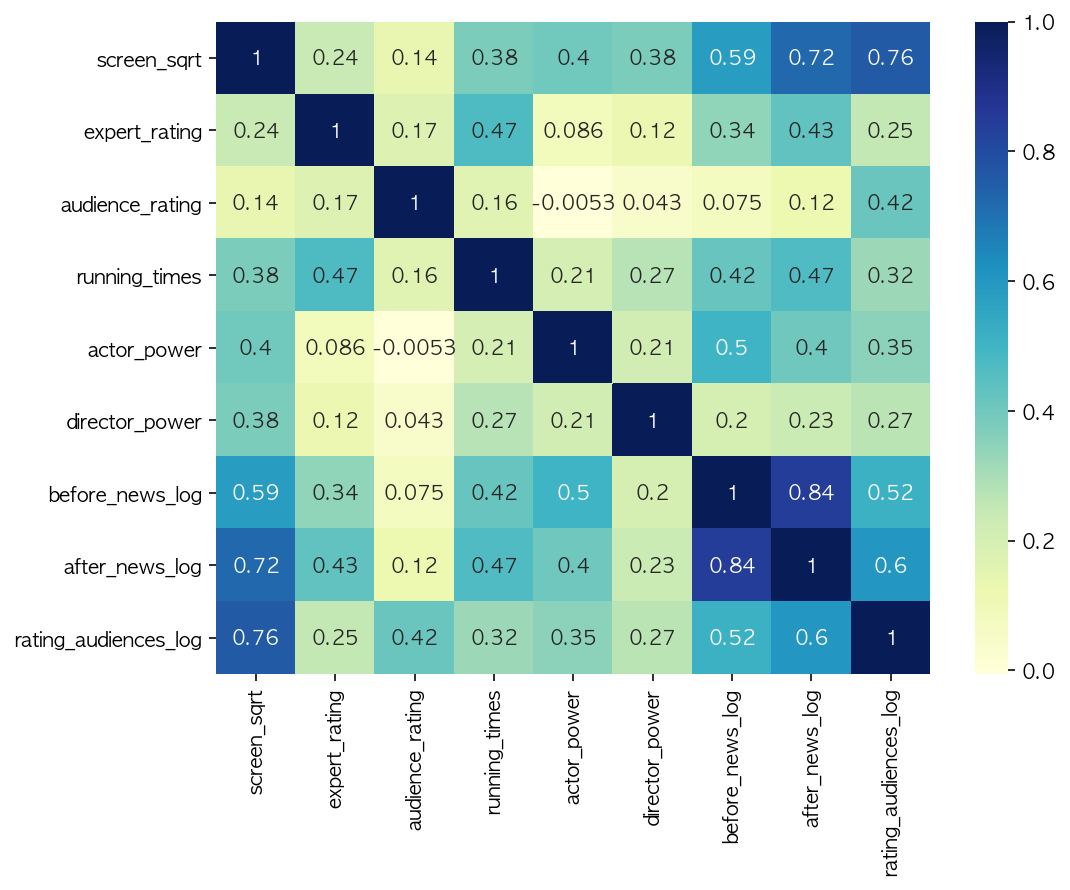

In [2329]:
plt.figure(figsize=(8, 6))
sns.heatmap(df9_1.corr(), annot=True, cmap="YlGnBu")

plt.show()

In [2330]:
sm.stats.anova_lm(result8, typ=2)

,sum_sq,df,F,PR(>F)
dist_cat,1.080159,2.0,1.340228,2.624597e-01
C(holiday),0.449047,1.0,1.114326,2.915093e-01
nation,2.412733,5.0,1.197458,3.087053e-01
genre,6.883910,13.0,1.314052,1.988762e-01
rate,2.653516,3.0,2.194934,8.738044e-02
C(sequel),2.541872,1.0,6.307750,1.224614e-02
C(original),0.060019,1.0,0.148941,6.996676e-01
scale(screen ** (4 / 7)),89.721759,1.0,222.647911,6.772440e-44
scale(expert_rating),1.066015,1.0,2.645357,1.043048e-01
scale(audience_rating),1.732954,1.0,4.300390,3.847033e-02


In [2331]:
# fig = plt.figure(figsize=(10, 46))
# sm.graphics.plot_partregress_grid(result10, fig=fig)
# fig.suptitle("")
# plt.show()

In [2332]:
# 15개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)' , 'np.log(rating_audiences_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model9 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df9)
result9 = model9.fit()
print(result9.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     98.70
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          3.82e-241
Time:                        15:56:24   Log-Likelihood:                -691.59
No. Observations:                 733   AIC:                             1453.
Df Residuals:                     698   BIC:                             1614.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [2333]:
# kfold 9

from sklearn.model_selection import KFold

kfold_dict_learn['9'] = []
kfold_dict['9'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df9)):
    df_train = df9.iloc[idx_train]
    df_test = df9.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'actor_power', 'director_power', 'running_times', 
                                   'before_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['9'].append(result.rsquared)
    kfold_dict['9'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['9'])/10)

학습 R2 = 0.83223387, 검증 R2 = 0.77607120
학습 R2 = 0.82537060, 검증 R2 = 0.84116747
학습 R2 = 0.82393869, 검증 R2 = 0.84148026
학습 R2 = 0.82956421, 검증 R2 = 0.79824784
학습 R2 = 0.82939305, 검증 R2 = 0.80062155
학습 R2 = 0.82967128, 검증 R2 = 0.80160536
학습 R2 = 0.82536912, 검증 R2 = 0.84009080
학습 R2 = 0.82912720, 검증 R2 = 0.80358459
학습 R2 = 0.83764706, 검증 R2 = 0.71434690
학습 R2 = 0.82423972, 검증 R2 = 0.85191633


In [2334]:
# model9의 테스트 R

pred = result9.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'actor_power', 'director_power', 'running_times',
                                'before_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.8002135828485589

In [2335]:
test_rsquare_dict['9'] = rsquared

In [2336]:
pred = result9.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['9'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243745844.749
RMSE =  2195960.779669061


In [2337]:
result_rsquare['result9_rsquared'] = result9.rsquared
result_adj_rsquare['result9_adj_rsquared'] = result9.rsquared_adj

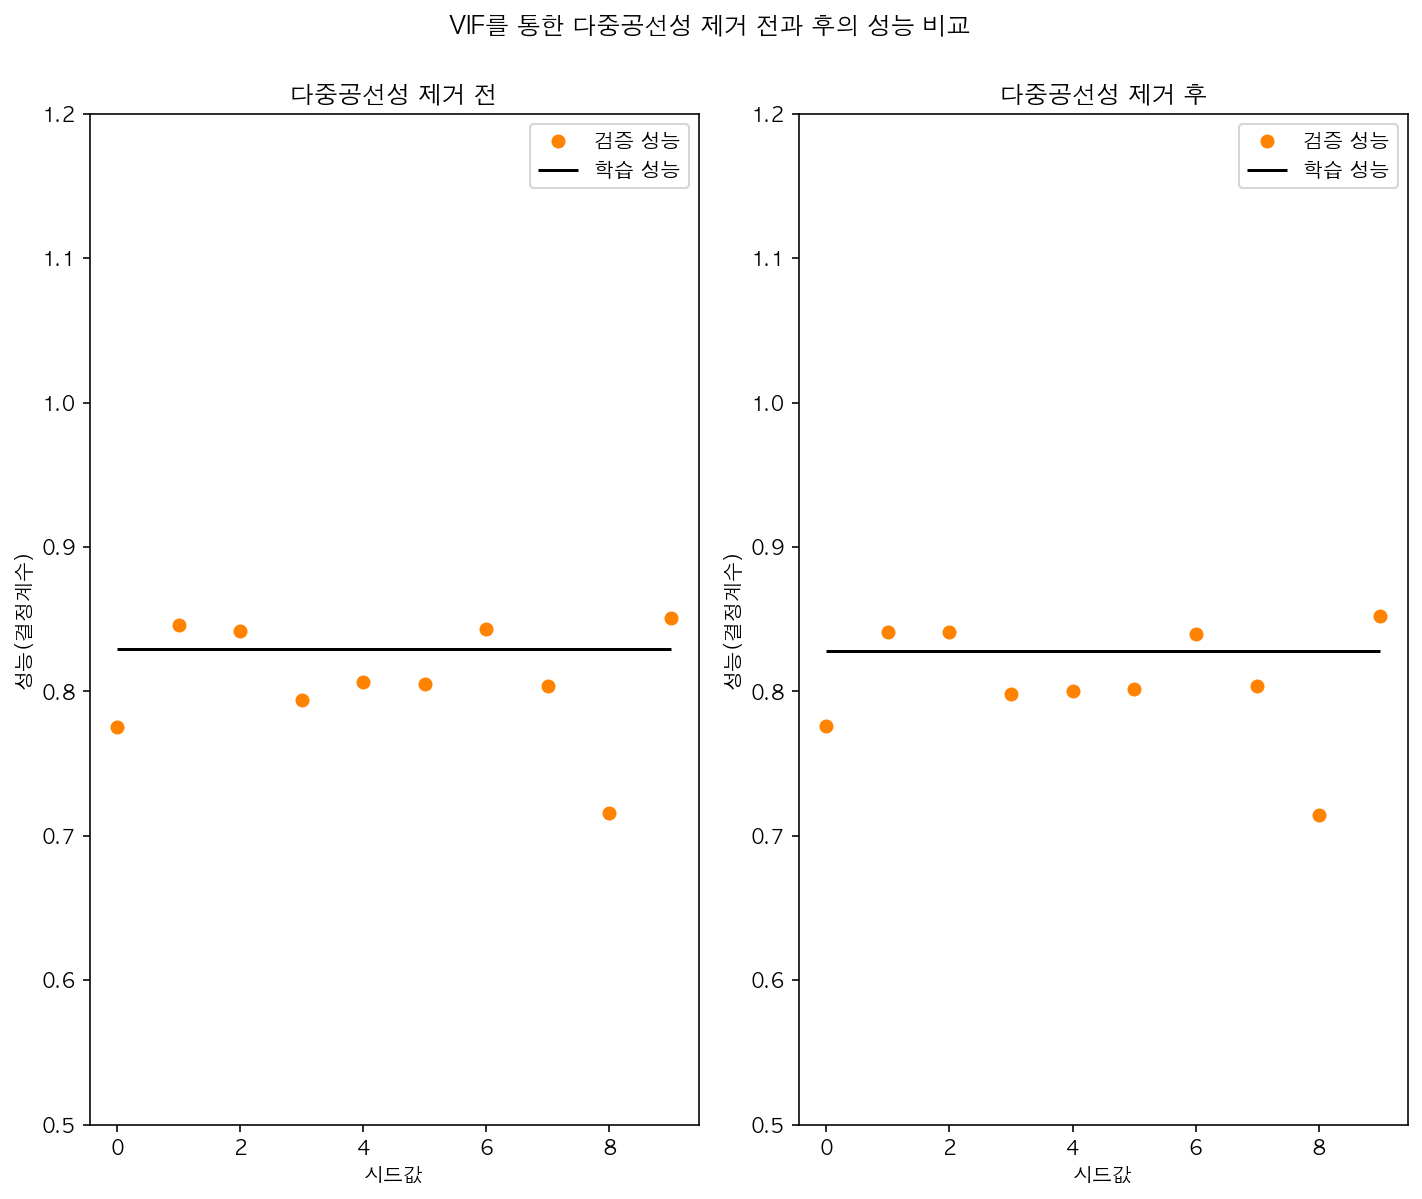

In [2338]:
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.plot(kfold_dict['8'], 'ro', label="검증 성능", color="#FF8200")
plt.hlines(result8.rsquared, 0, 9, label="학습 성능")
plt.legend()
plt.xlabel("시드값")
plt.ylabel("성능(결정계수)")
plt.title("다중공선성 제거 전")
plt.ylim(0.5, 1.2)

plt.subplot(122)
plt.plot(kfold_dict['9'], 'ro', label="검증 성능", color="#FF8200")
plt.hlines(result9.rsquared, 0, 9, label="학습 성능")
plt.legend()
plt.xlabel("시드값")
plt.ylabel("성능(결정계수)")
plt.title("다중공선성 제거 후")
plt.ylim(0.5, 1.2)

plt.suptitle("VIF를 통한 다중공선성 제거 전과 후의 성능 비교", y=1.04)
plt.tight_layout()
plt.show()

# model10
- ANOVA 테스트로 범주형 변수 선별하고 성능 변화 확인하기
    - 범주형 컬럼 중 anova f-test의 p-value가 가장 높은 세개 먼저 제거
        - nation, genre, rate

In [2339]:
df10 = df9.copy()

In [2340]:
# 실수형 피쳐만 다중공선성 VIF로 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
df10_1 = df10.drop(columns=['log_aud', 'aud_nationwide'])

df10_1['screen_sqrt'] = df10_1['screen'].apply(lambda num : num**(4/7))
df10_1['before_news_log'] = df10_1['before_news_0to1'].apply(lambda news : np.log(news))
# df10_1['after_news_log'] = df10_1['after_news_0to1'].apply(lambda news : np.log(news))
df10_1['rating_audiences_log'] = df10_1['rating_audiences_0to1'].apply(lambda aud : np.log(aud))

df10_1 = df10_1[['screen_sqrt', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news_log', 'rating_audiences_log']]

vif["VIF Factor"] = [variance_inflation_factor(
    df10_1.values, i) for i in range(df10_1.shape[1])]
vif["features"] = df10_1.columns
vif

,VIF Factor,features
0,22.869246,screen_sqrt
1,10.846557,expert_rating
2,32.096996,audience_rating
3,35.360184,running_times
4,2.089592,actor_power
5,1.269004,director_power
6,13.771127,before_news_log
7,36.710879,rating_audiences_log


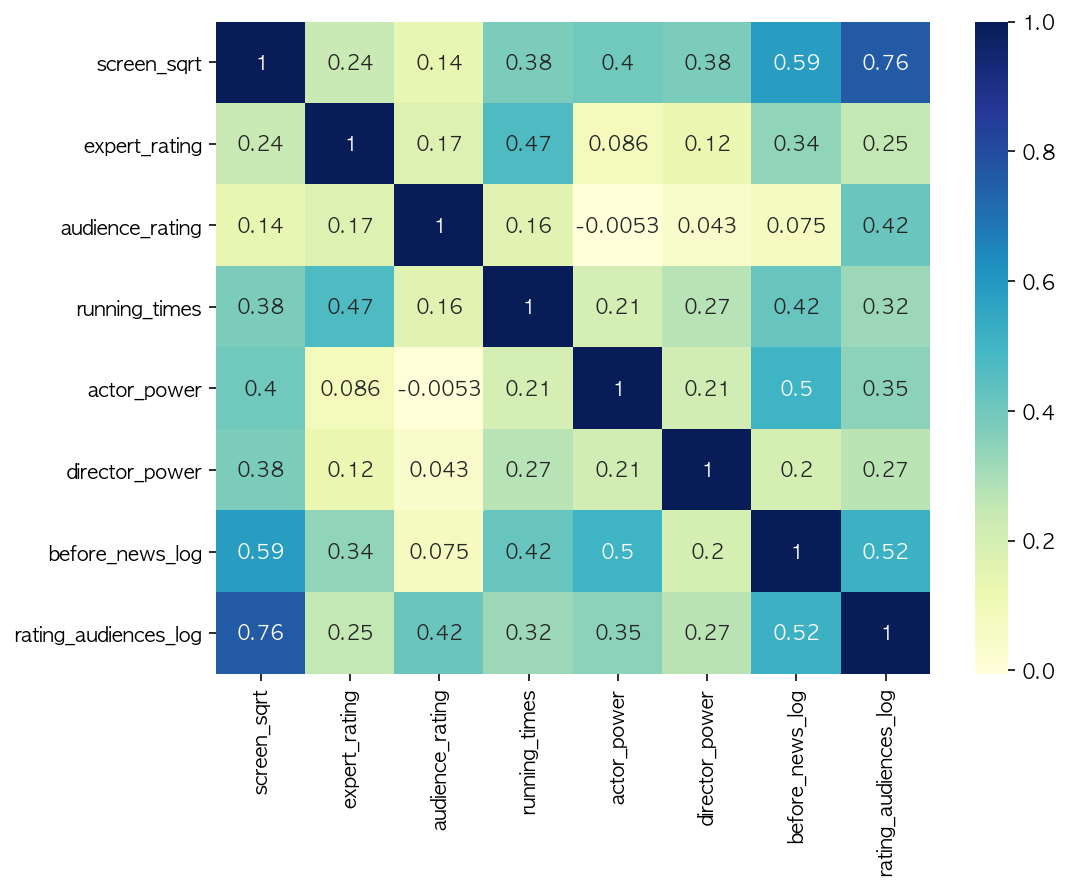

In [2341]:
plt.figure(figsize=(8, 6))
sns.heatmap(df10_1.corr(), annot=True, cmap="YlGnBu")

plt.show()

In [2342]:
# anova 테스트 -> VIF로 범주형을 확인 못하니까 카테고리의 모델 영향력을 anova로 확인해서 상위 3개 제거
# 도메인적으로 연결 가능한지 보기

sm.stats.anova_lm(result9, typ=2)

,sum_sq,df,F,PR(>F)
dist_cat,1.263075,2.0,1.556343,2.116370e-01
C(holiday),0.555827,1.0,1.369765,2.422517e-01
nation,2.206640,5.0,1.087596,3.658463e-01
genre,7.009334,13.0,1.328739,1.904423e-01
rate,2.806740,3.0,2.305617,7.556368e-02
C(sequel),2.339061,1.0,5.764315,1.661553e-02
C(original),0.065503,1.0,0.161423,6.879726e-01
scale(screen ** (4 / 7)),117.683449,1.0,290.015758,1.195360e-54
scale(expert_rating),1.967209,1.0,4.847933,2.800568e-02
scale(audience_rating),1.826073,1.0,4.500122,3.424425e-02


In [2343]:
anova_df = sm.stats.anova_lm(result9, typ=2)
anova_df.sort_values(by=['PR(>F)'], ascending=False)

,sum_sq,df,F,PR(>F)
C(original),0.065503,1.0,0.161423,6.879726e-01
scale(running_times),0.164817,1.0,0.406171,5.241285e-01
nation,2.206640,5.0,1.087596,3.658463e-01
scale(actor_power),0.452680,1.0,1.115573,2.912392e-01
C(holiday),0.555827,1.0,1.369765,2.422517e-01
dist_cat,1.263075,2.0,1.556343,2.116370e-01
genre,7.009334,13.0,1.328739,1.904423e-01
rate,2.806740,3.0,2.305617,7.556368e-02
scale(audience_rating),1.826073,1.0,4.500122,3.424425e-02
scale(expert_rating),1.967209,1.0,4.847933,2.800568e-02


In [2344]:
df10 = df9.drop(columns=['holiday', 'nation', 'rate', 'original'])

In [2345]:
# ?개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)' , 'np.log(rating_audiences_0to1)']
feature_names = ["scale({})".format(name)
                 for name in feature_names] + ['dist_cat', 'genre', 'C(sequel)']
model10 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df10)
result10 = model10.fit()
print(result10.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     138.3
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          2.38e-248
Time:                        15:56:48   Log-Likelihood:                -699.31
No. Observations:                 733   AIC:                             1449.
Df Residuals:                     708   BIC:                             1564.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [2346]:
# kfold 10

from sklearn.model_selection import KFold

kfold_dict_learn['10'] = []
kfold_dict['10'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'dist_cat', 'genre', 'sequel']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['10'].append(result.rsquared)
    kfold_dict['10'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['10'])/10)

학습 R2 = 0.82763682, 검증 R2 = 0.78168201
학습 R2 = 0.82121103, 검증 R2 = 0.84485021
학습 R2 = 0.81928457, 검증 R2 = 0.84876893
학습 R2 = 0.82609055, 검증 R2 = 0.79635706
학습 R2 = 0.82547045, 검증 R2 = 0.80195383
학습 R2 = 0.82603435, 검증 R2 = 0.79932756
학습 R2 = 0.82132541, 검증 R2 = 0.84044324
학습 R2 = 0.82630846, 검증 R2 = 0.79413184
학습 R2 = 0.83424762, 검증 R2 = 0.71082107
학습 R2 = 0.82006589, 검증 R2 = 0.85451441


In [2347]:
# model10의 테스트 R

pred = result10.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'dist_cat', 'genre', 'sequel']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.8005606168285515

In [2348]:
test_rsquare_dict['10'] = rsquared

In [2349]:
len(test_rsquare_dict)

10

In [2350]:
pred = result10.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['10'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243688285.789
RMSE =  2195960.766563417


In [2351]:
result_rsquare['result10_rsquared'] = result10.rsquared
result_adj_rsquare['result10_adj_rsquared'] = result10.rsquared_adj

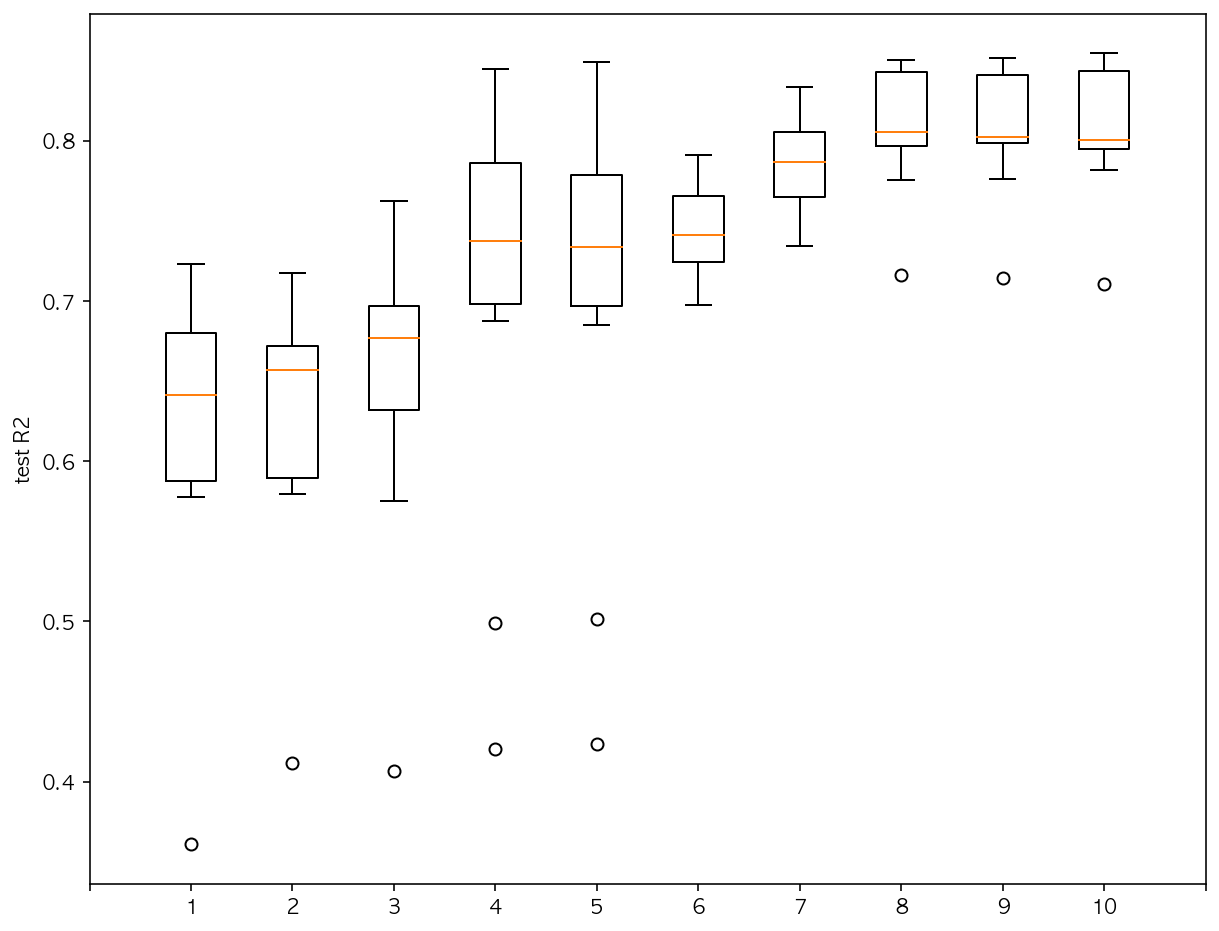

In [2352]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(10, 8))
plt.boxplot((kfold_df['1'], kfold_df['2'], kfold_df['3'], kfold_df['4'],
             kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['8'], kfold_df['9'], kfold_df['10']))
plt.ylabel("test R2")
plt.xticks(np.arange(12), ('', '1', '2', '3',
                           '4', '5', '6', '7', '8', '9', '10'))

plt.show()

In [2353]:
len(test_rsquare_dict)

10

In [2354]:
# RMSE_dict

In [2355]:
model_name_arr = []
for key, value in test_rsquare_dict.items():
    model_name_arr.append('model' + str(key))   
result_df = pd.DataFrame(columns=['model'])
result_df['model'] = model_name_arr

test_rsquare_arr = []
for key, value in test_rsquare_dict.items():
    test_rsquare_arr.append(value)
result_df['test_rsquare'] = test_rsquare_arr    

RMSE_arr = []
for key, value in RMSE_dict.items():
    RMSE_arr.append(value)
result_df['RMSE'] = RMSE_arr

rsquare_arr = []
for key, value in result_rsquare.items():
    rsquare_arr.append(value)
result_df['rsquare'] = rsquare_arr

adj_rsquare_arr = []
for key, value in result_adj_rsquare.items():
    adj_rsquare_arr.append(value)
result_df['adj_rsquare'] = adj_rsquare_arr

In [2356]:
result_df.head(2)

,model,test_rsquare,RMSE,rsquare,adj_rsquare
0,model1,0.606384,1.216819e+06,0.652259,0.638055
1,model2,0.624336,1.188748e+06,0.665968,0.651343


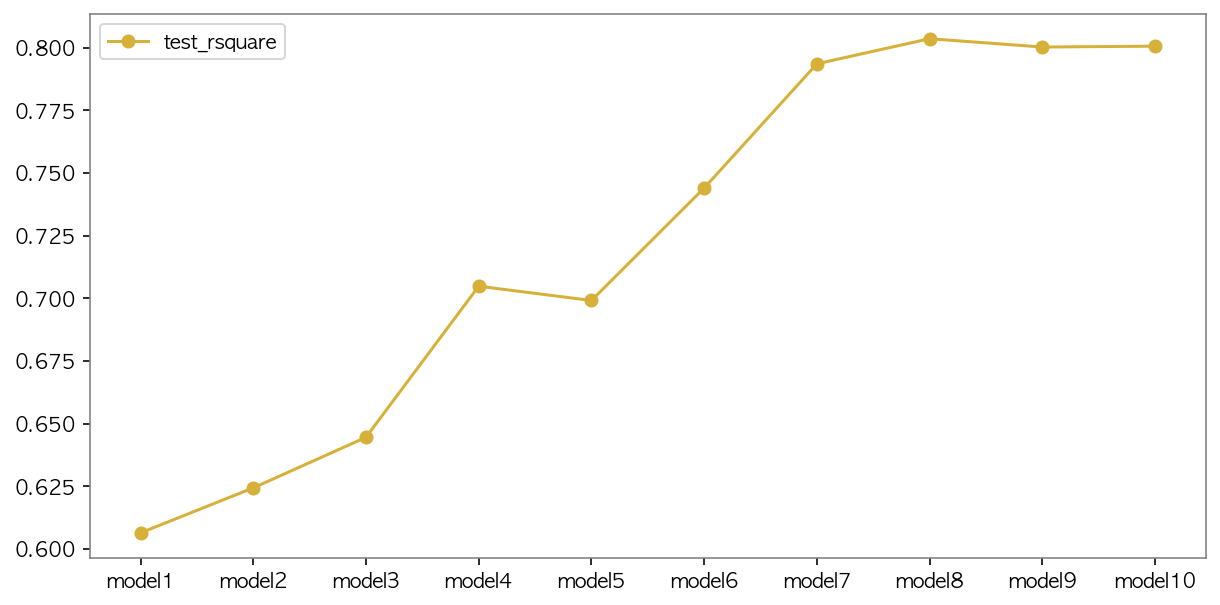

In [2357]:
# test_R2

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df['model'], result_df['test_rsquare'], "go-" ,color='#D6B038', label='test_rsquare')
plt.legend()
plt.show()

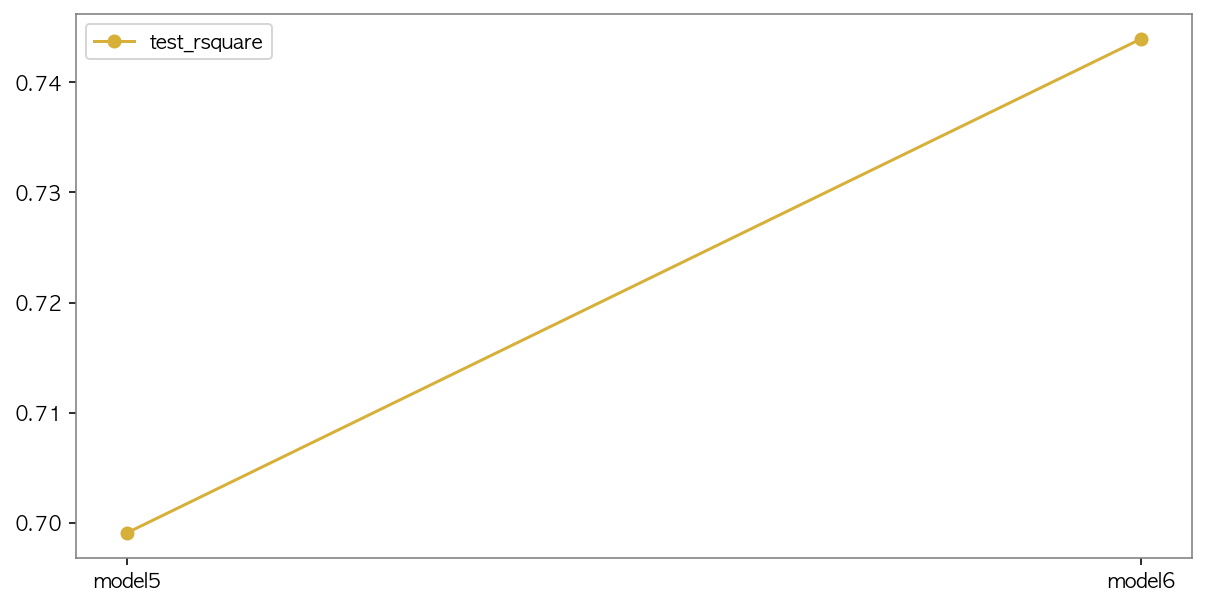

In [2358]:
# test_R2

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df[4:6]['model'], result_df[4:6]['test_rsquare'], "go-" ,color='#D6B038', label='test_rsquare')
plt.legend()
plt.show()

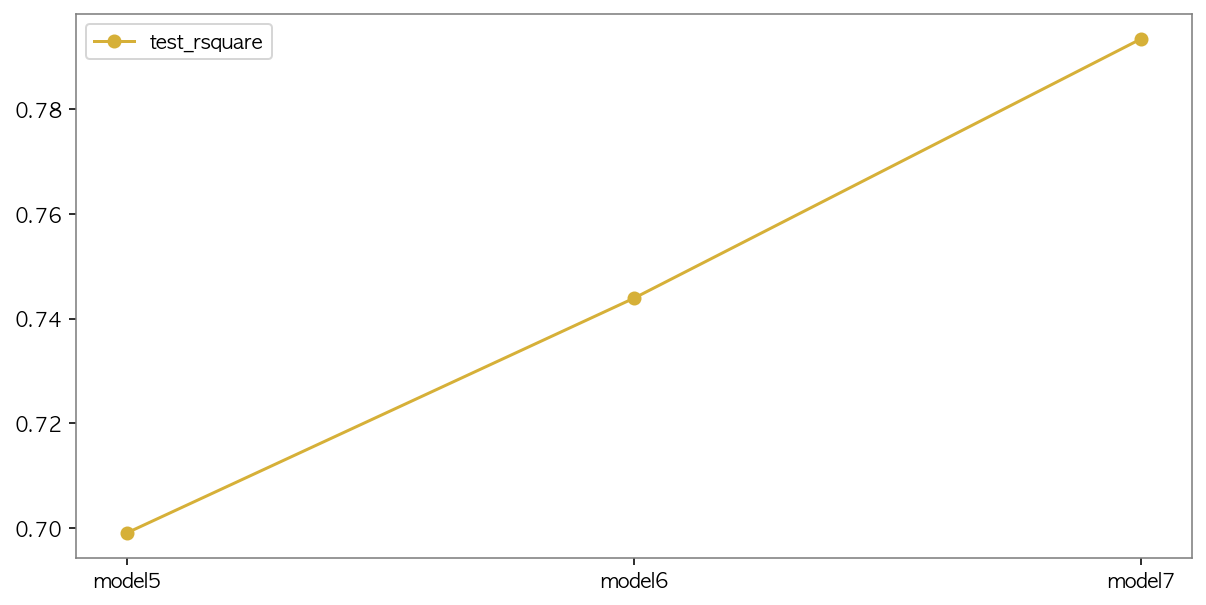

In [2359]:
# test_R2

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df[4:7]['model'], result_df[4:7]['test_rsquare'], "go-" ,color='#D6B038', label='test_rsquare')
plt.legend()
plt.show()

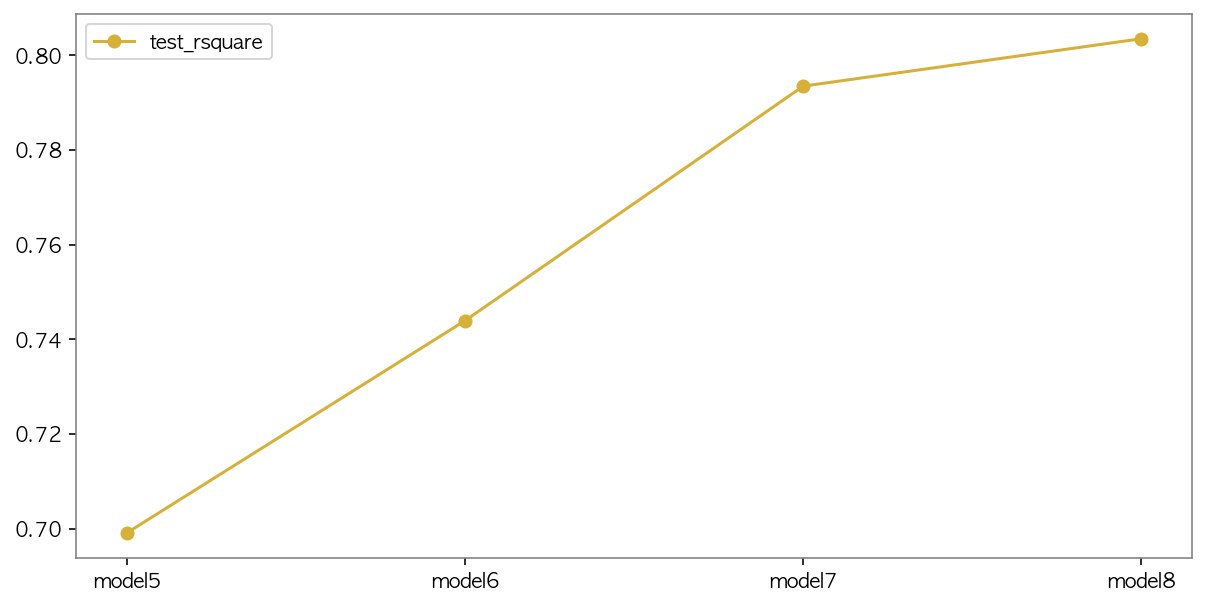

In [2360]:
# test_R2

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df[4:8]['model'], result_df[4:8]['test_rsquare'], "go-" ,color='#D6B038', label='test_rsquare')
plt.legend()
plt.show()

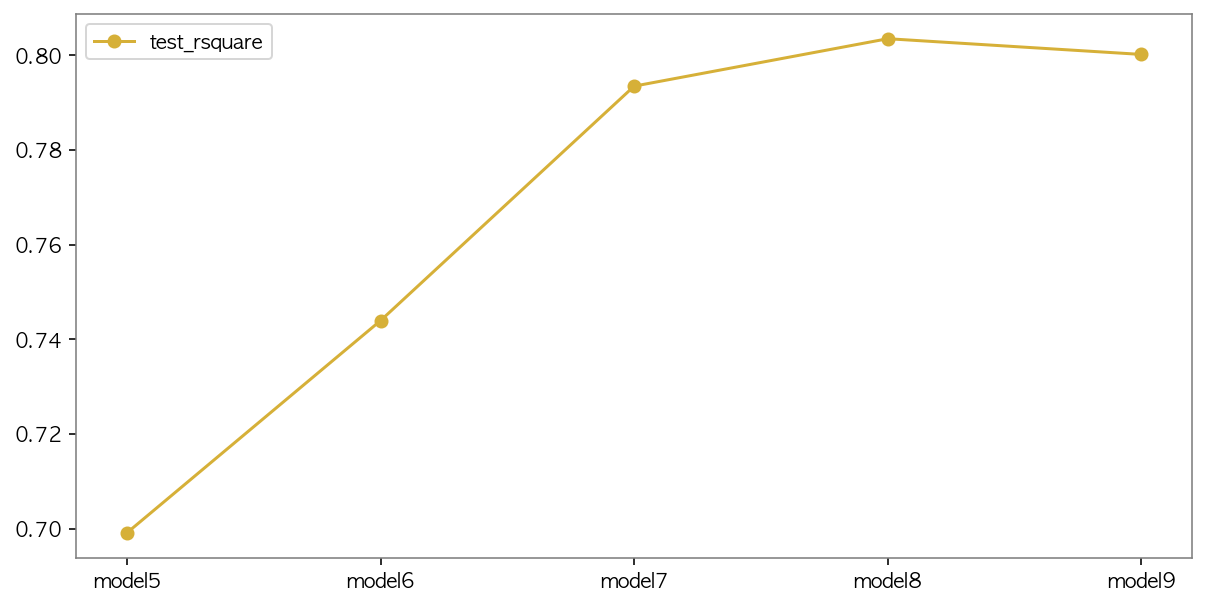

In [2361]:
# test_R2

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df[4:9]['model'], result_df[4:9]['test_rsquare'], "go-" ,color='#D6B038', label='test_rsquare')
plt.legend()
plt.show()

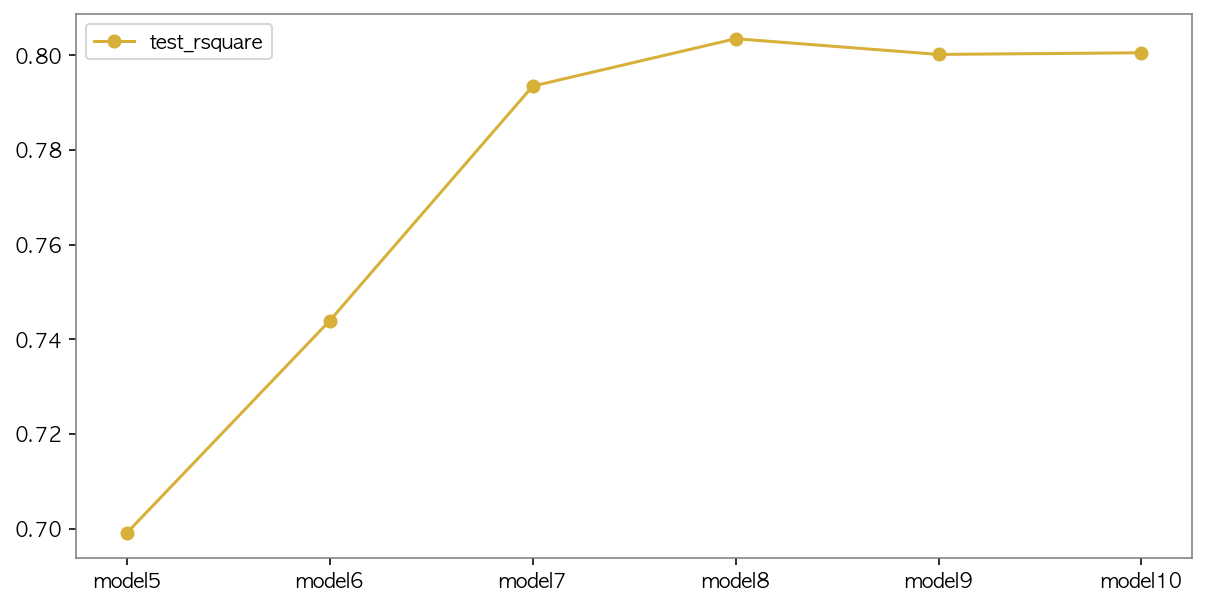

In [2362]:
# test_R2

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df[4:10]['model'], result_df[4:10]['test_rsquare'], "go-" ,color='#D6B038', label='test_rsquare')
plt.legend()
plt.show()

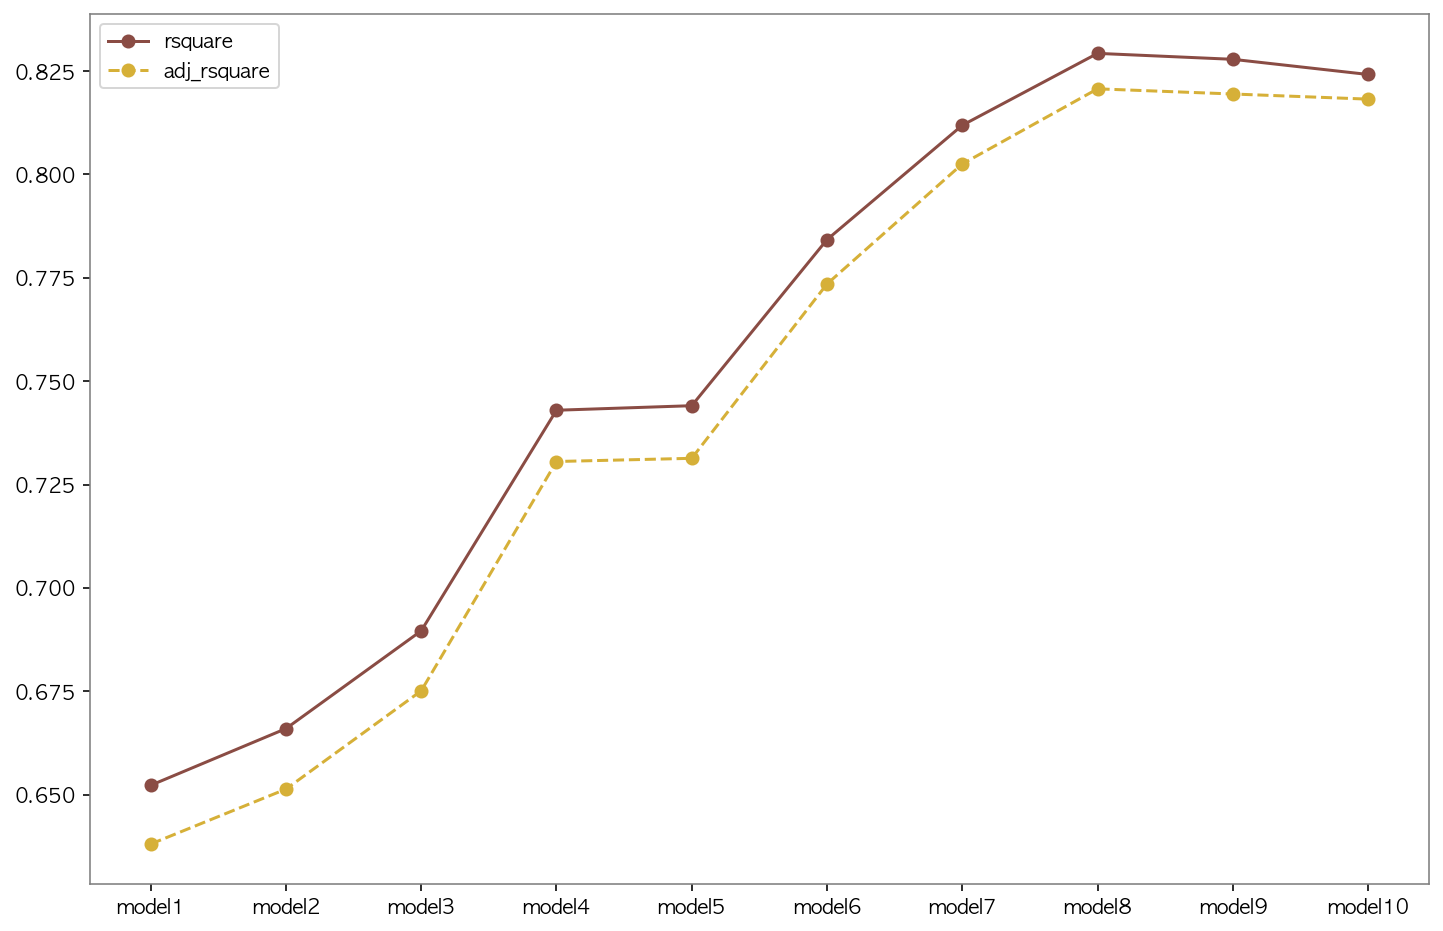

In [2363]:
# fig, ax = plt.subplots()
# sns.set(rc={'figure.figsize':(10, 6)})
# plt.axis('on')
# plt.grid(b=None)
# plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df['model'], result_df['rsquare'], "go-" ,color='#8A4C44', label='rsquare')
ax.plot(result_df['model'], result_df['adj_rsquare'], "go--",color='#D6B038', label='adj_rsquare')
ax.legend()
plt.show()


In [2364]:
# fig, ax = plt.subplots()

# sns.set(rc={'figure.figsize':(10, 6)})
# sns.pointplot(x='model_num', y='rsquare', data=result_df_1to5, ax=ax, color='#8A4C44', labels='rsquare', markers=['o'])
# sns.pointplot(x='model_num', y='adj_rsquare', data=result_df_1to5, ax=ax, color='#C8852C', labels='adj_rsquare', markers=['o'], linestyles=['--'])
# fig.legend(labels=['rsquare', 'adj_rsquare'])
# labels = ax.get_legend_handles_labels()[1]

# fig.show()
# # ax.set_xticklabels(labels, rotation=-30)

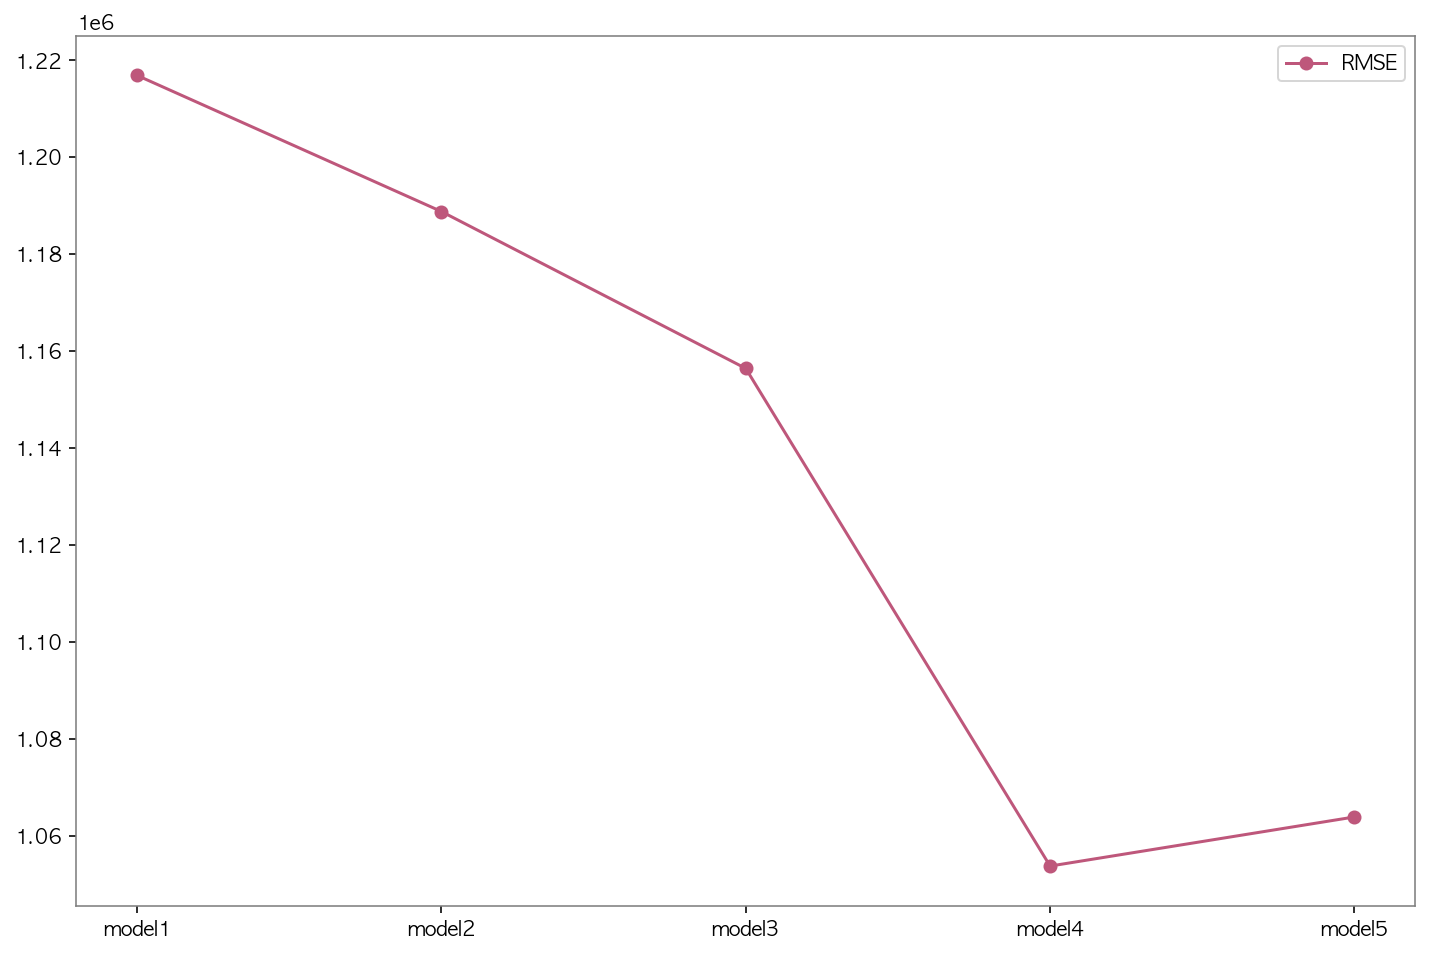

In [2365]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df[:5]['model'], result_df[:5]['RMSE'], "go-" ,color='#BE577B', label='RMSE')
plt.legend()
plt.show()

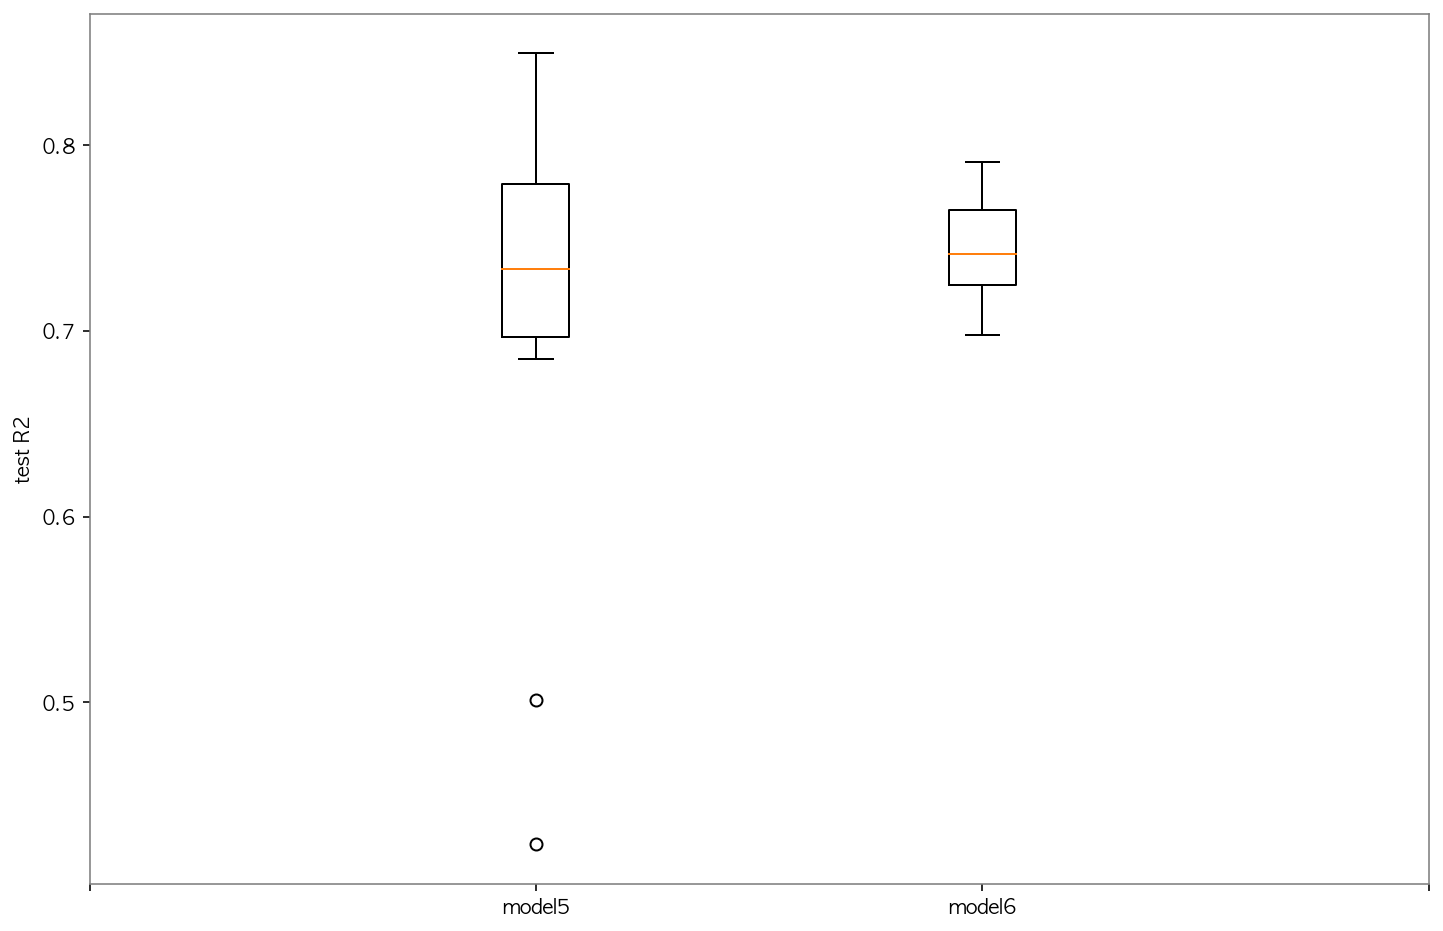

In [2366]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.boxplot((kfold_df['5'], kfold_df['6']))
plt.ylabel("test R2")
plt.xticks(np.arange(4), ('', 'model5', 'model6'))

plt.show()

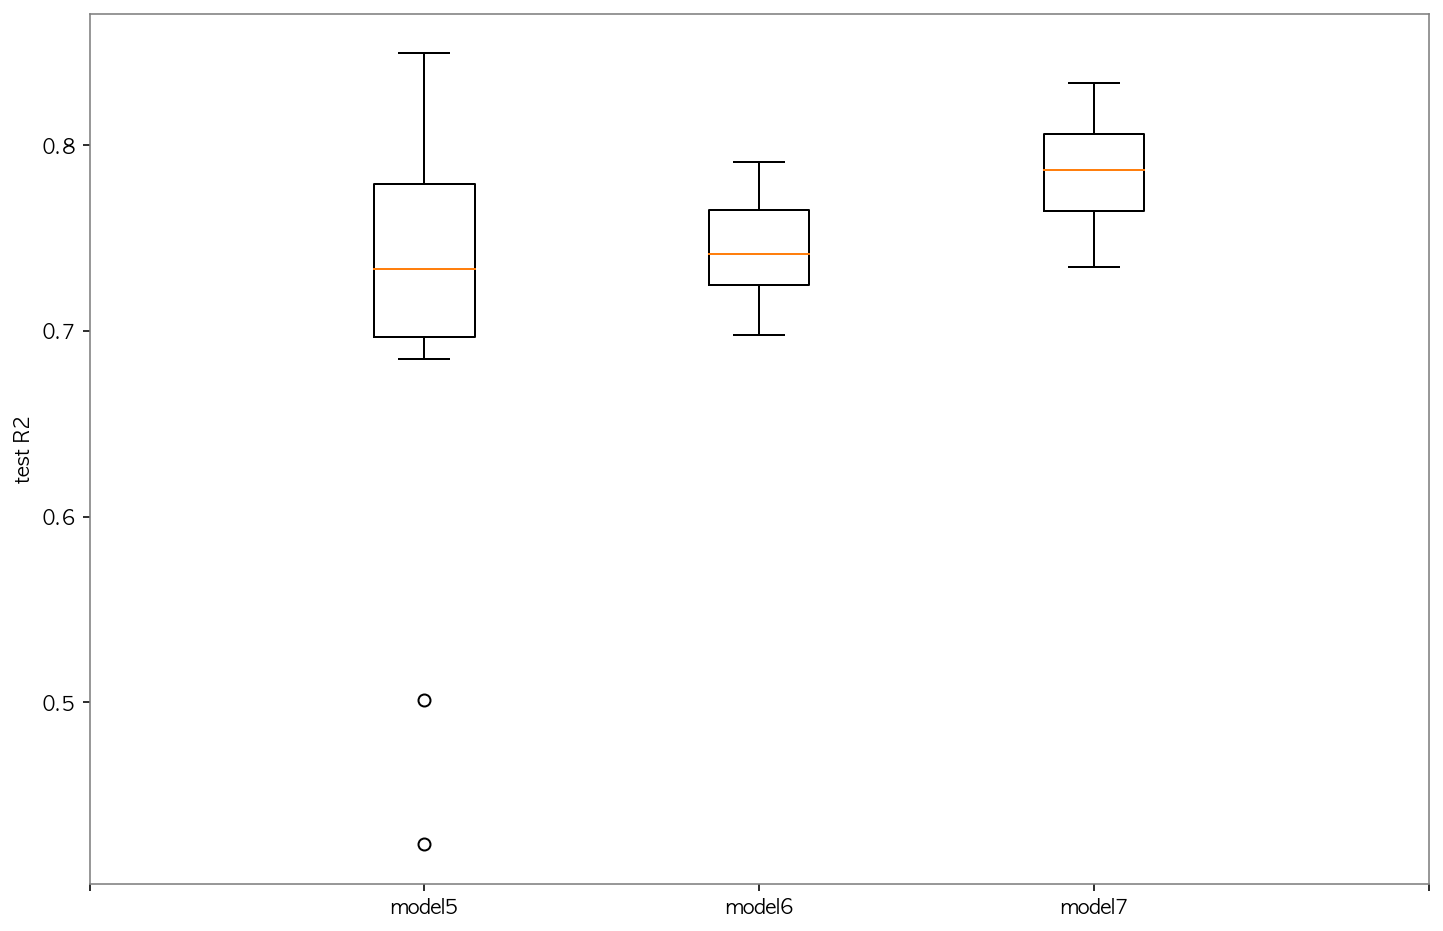

In [2367]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7']))
plt.ylabel("test R2")
plt.xticks(np.arange(5), ('', 'model5', 'model6', 'model7'))

plt.show()

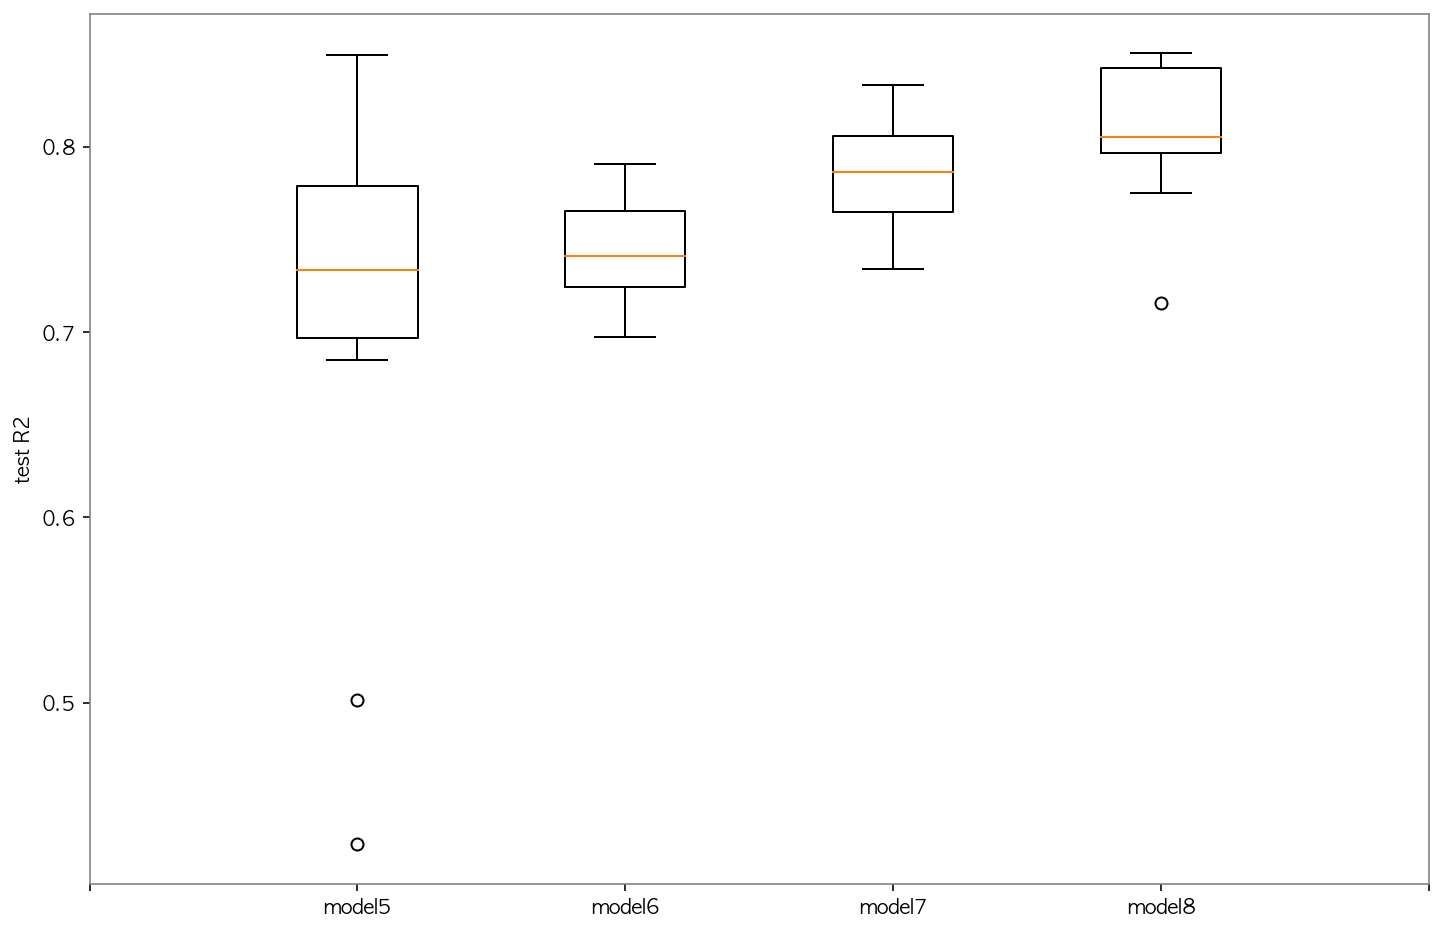

In [2368]:
# 아웃라이어 제거한 모델 2개를 하나(model8로 표현)

for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['8']))
plt.ylabel("test R2")
plt.xticks(np.arange(6), ('', 'model5', 'model6', 'model7', 'model8',))

plt.show()

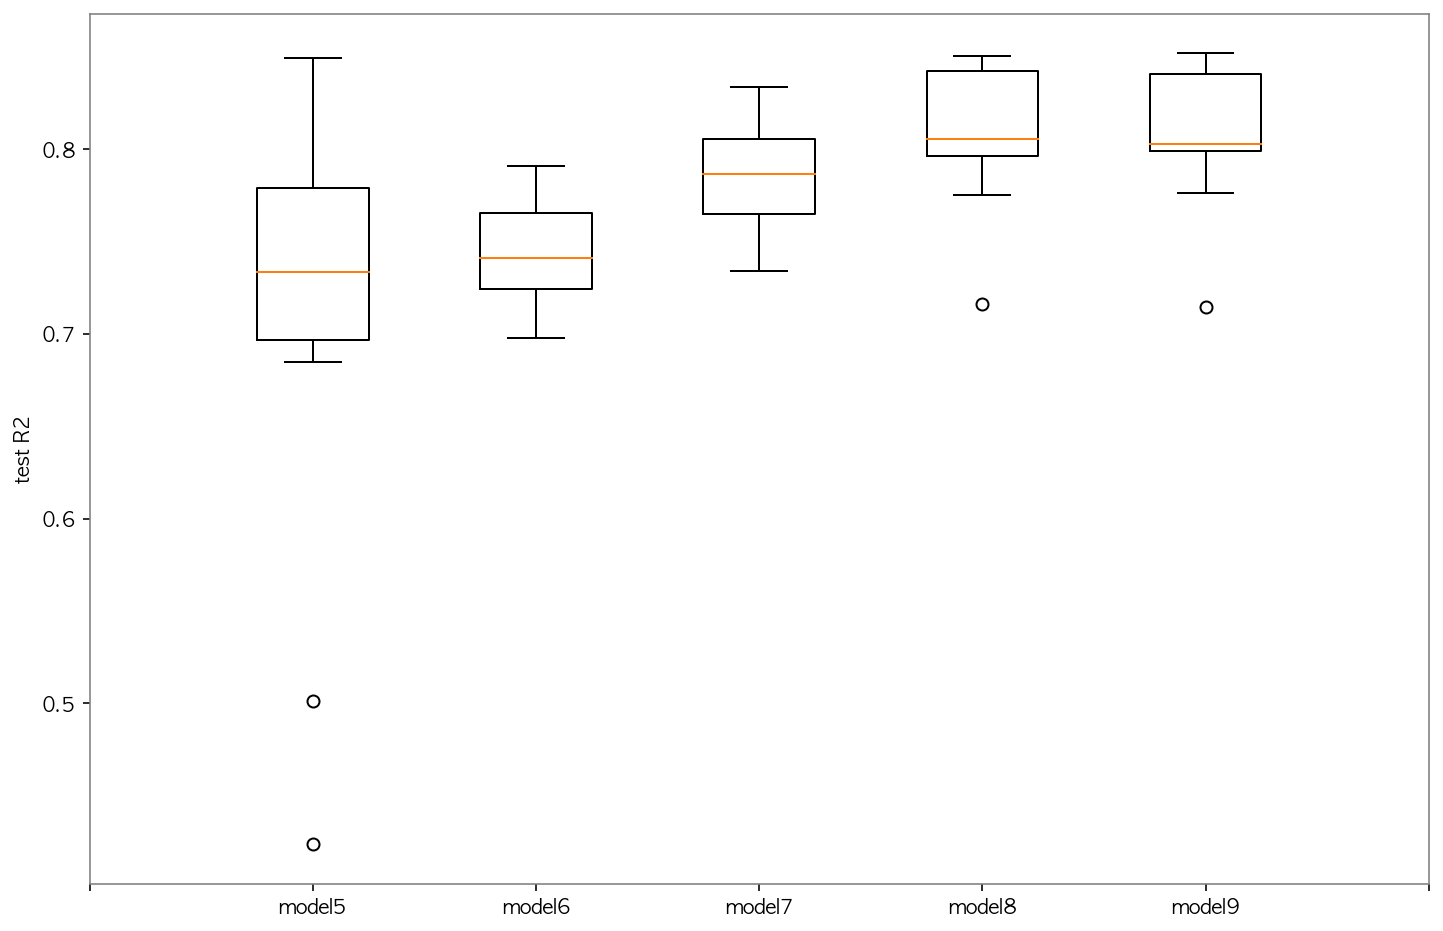

In [2369]:
# VIF로 한개 컬럼 제거 

for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['8'], kfold_df['9']))
plt.ylabel("test R2")
plt.xticks(np.arange(7), ('', 'model5', 'model6', 'model7', 'model8', 'model9'))

plt.show()

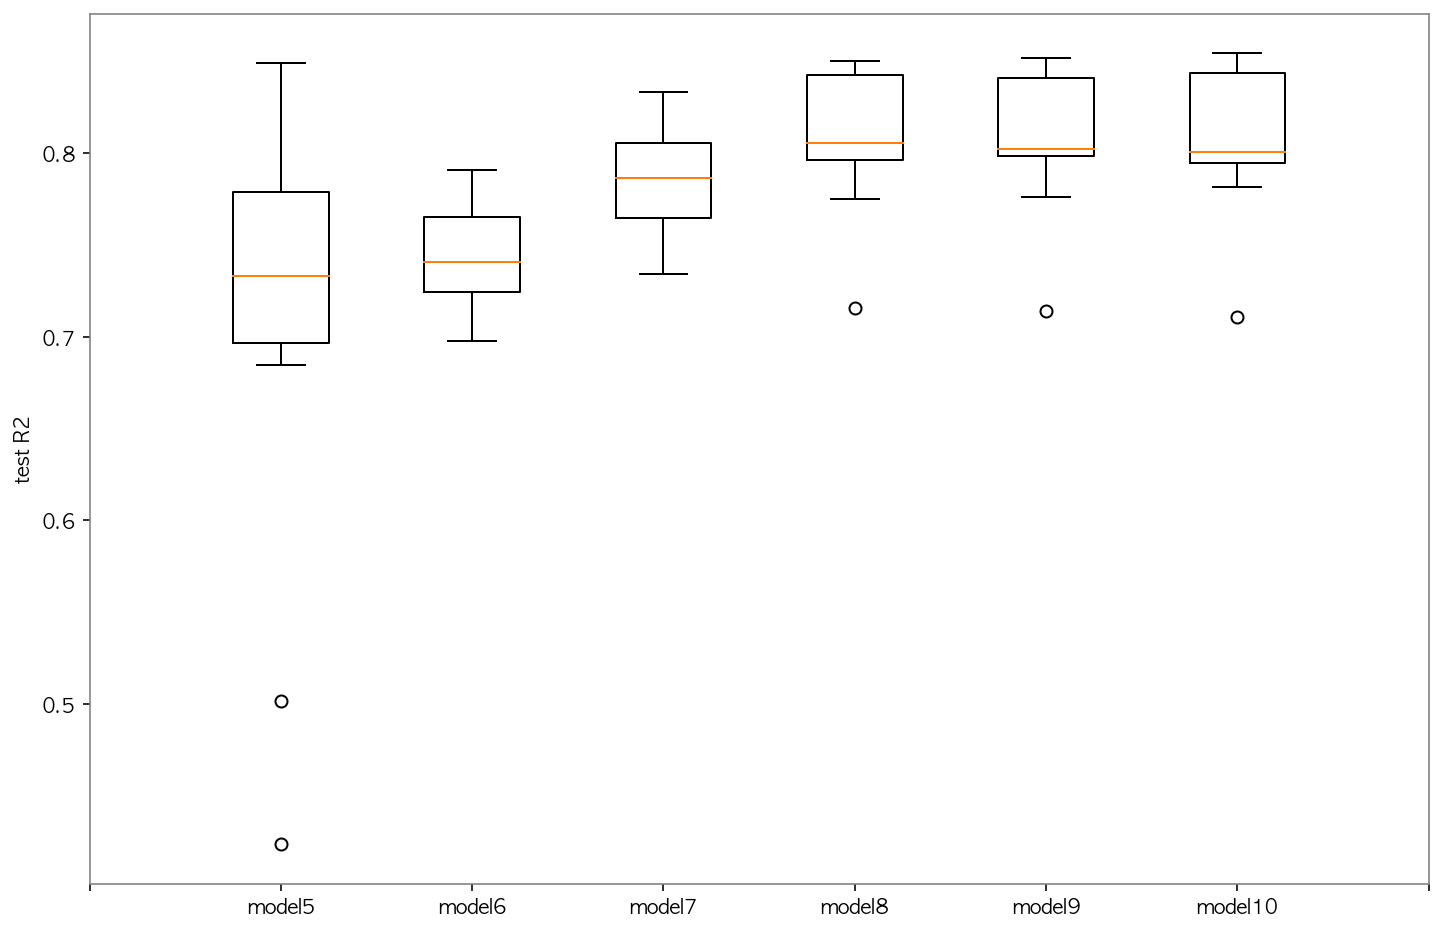

In [2370]:
# Anova로 세개 컬럼 제거 

for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['8'], kfold_df['9'], kfold_df['10']))
plt.ylabel("test R2")
plt.xticks(np.arange(8), ('', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10'))

plt.show()

- 종속변수 로그변환
    - QQ플롯의 변화, 정속변수의 값 변화
- 스크린에 root씌우고 한 도메인적인 근거 찾기-> 표, 그래프 
- 뉴스 등에 로그 처리한 이유 -> 스캐터플롯 등의 그래프
- 변형을 거친 수치 독립변수들 모두 이런 과정들 표나 그래프로 나타내기
- kfold 박스플롯을 result별로 순서대로 따로 나타내기 
- 아웃라이어 

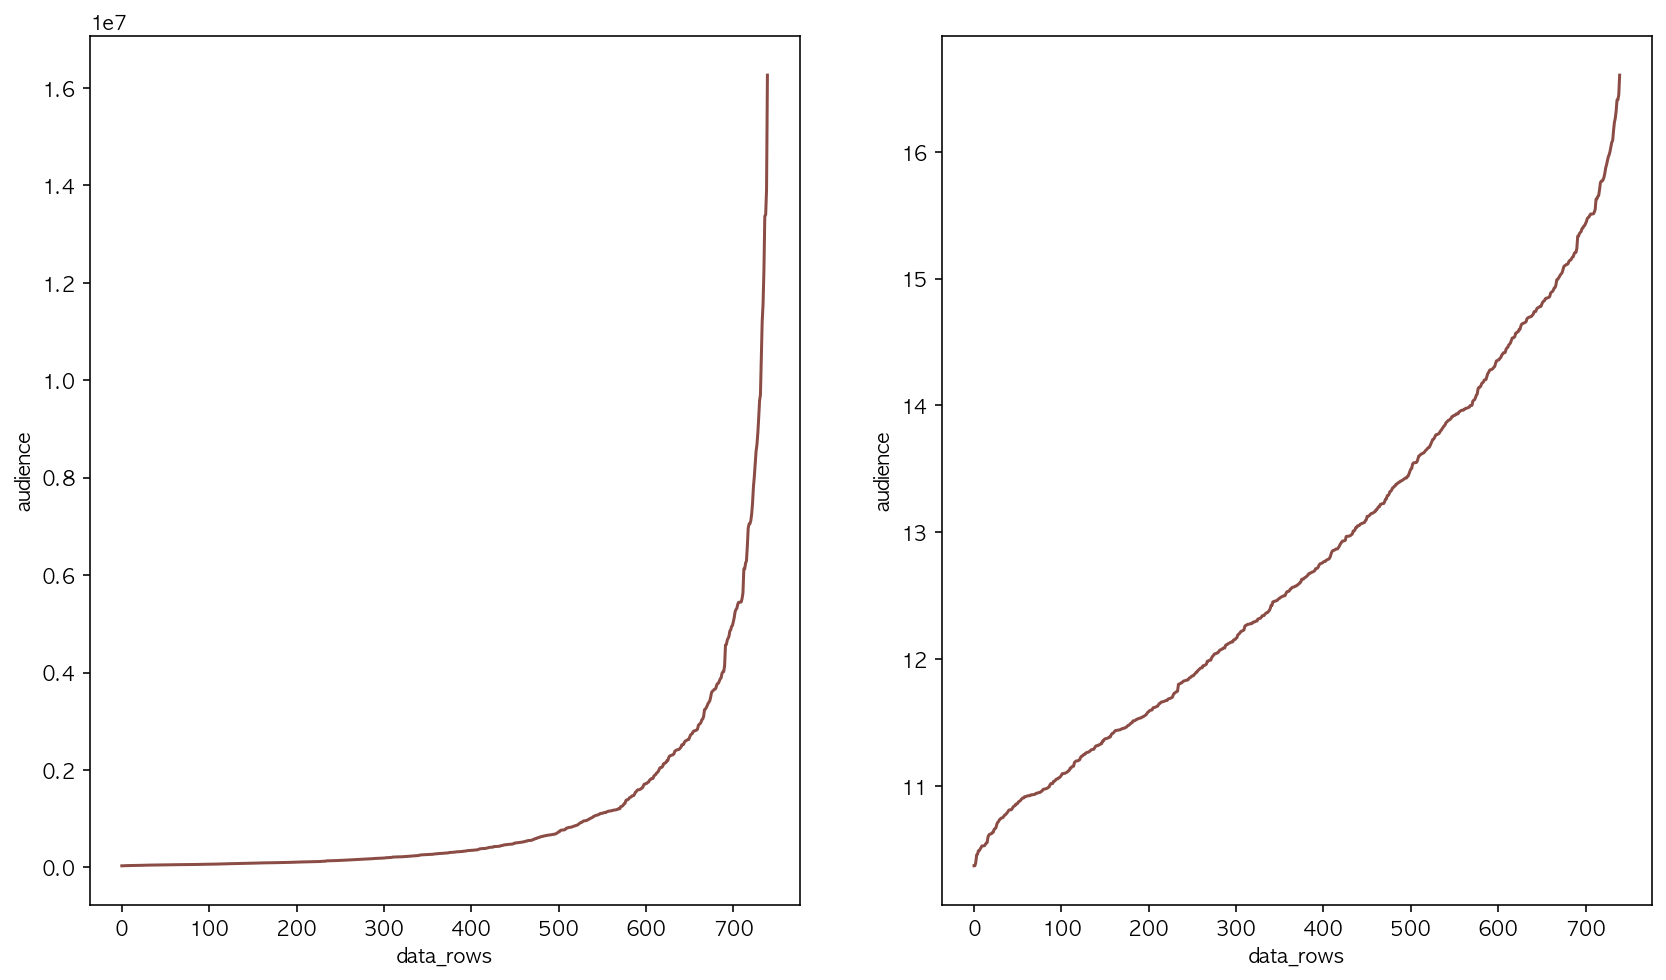

In [2371]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
# plt.title("로그변환 전")
plt.plot(df6['aud_nationwide'].sort_values().reset_index(drop=True), color="#8A4C44")
plt.xlabel('data_rows')
plt.ylabel('audience')
plt.subplot(122)
# plt.title("로그변환 후")
plt.plot(np.log(df6['aud_nationwide'].sort_values().reset_index(drop=True)), color="#8A4C44")
plt.xlabel('data_rows')
plt.ylabel('audience')
plt.show()

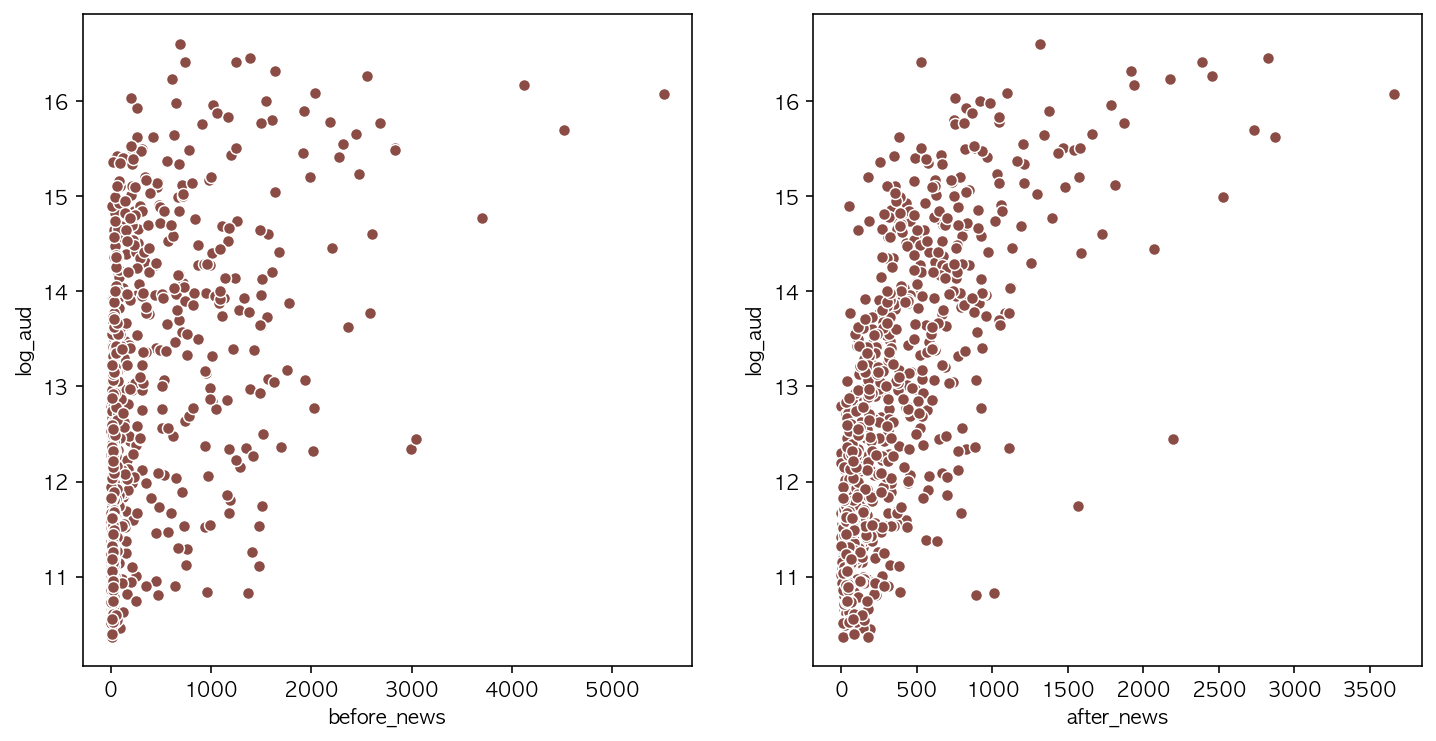

In [2372]:
# news 컬럼 변형

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="before_news", y="log_aud", data=df7, color="#8A4C44")
plt.subplot(122)
sns.scatterplot(x="after_news", y="log_aud", data=df7, color="#8A4C44")
plt.show()

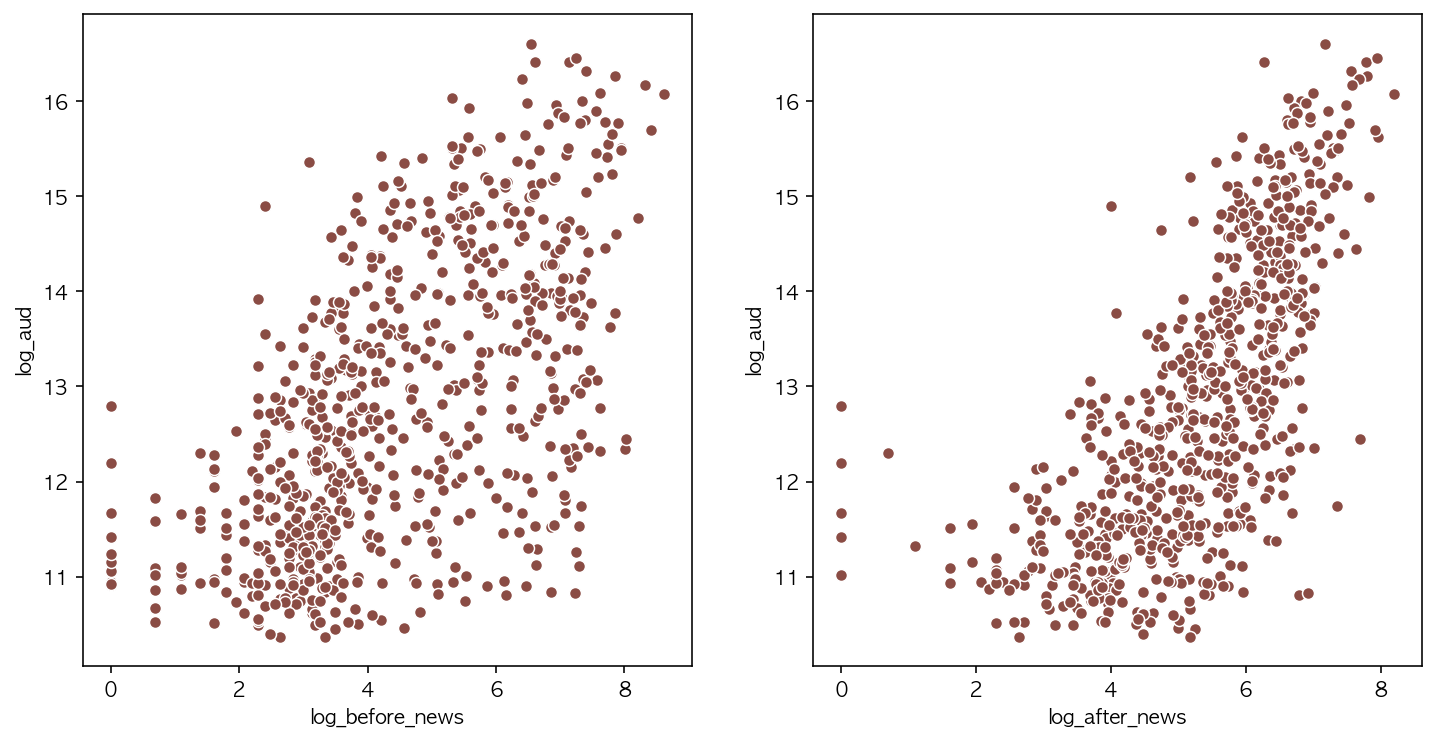

In [2373]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="log_before_news", y="log_aud", data=df7, color="#8A4C44")
plt.subplot(122)
sns.scatterplot(x="log_after_news", y="log_aud", data=df7, color="#8A4C44")
plt.show()

# model12 => ridge, lasso, elastic 적용
- 미처 제거하지 못한 다중공선성 제거를 위한 정규화
    - Ridge, Lasso, Elastic

In [2444]:
# result10_ridge = model10.fit_regularized(alpha=0.01, L1_wt=0, refit=True)
# result10_lasso = model10.fit_regularized(alpha=0.01, L1_wt=1, refit=True)

In [2445]:
df10_2 = df10.copy()

In [2446]:
df10_2['screen_sqrt'] = df10_2['screen'].apply(lambda num : num**(4/7))
df10_2['before_news_log'] = df10_2['before_news_0to1'].apply(lambda news : np.log(news))
df10_2['after_news_log'] = df10_2['after_news_0to1'].apply(lambda news : np.log(news))
df10_2['rating_audiences_log'] = df10_2['rating_audiences_0to1'].apply(lambda aud : np.log(aud))

In [2447]:
# df10_2.columns

In [2448]:
df10_2 = pd.concat([df10_2, pd.get_dummies(df10_2['genre'], prefix='genre_dummy')], axis=1)
df10_2 = pd.concat([df10_2, pd.get_dummies(df10_2['sequel'], prefix='sequel_dummy')], axis=1)
# df10_2 = pd.concat([df10_2, pd.get_dummies(df10_2['original'], prefix='original_dummy')], axis=1)
df10_2 = pd.concat([df10_2, pd.get_dummies(df10_2['dist_cat'], prefix='dist_cat_dummy')], axis=1)

In [2449]:
df10_2.head(1)

,title,director,distributor,release_date,release_season,screen,genre,type,expert_rating,starring_actors,...,genre_dummy_애니메이션,genre_dummy_액션,genre_dummy_어드벤처,genre_dummy_코미디,genre_dummy_판타지,sequel_dummy_0,sequel_dummy_1,dist_cat_dummy_A,dist_cat_dummy_B,dist_cat_dummy_C
0,인사이드 아웃,피트 닥터,월트디즈니컴퍼니코리아(주),20150709,summer,777,애니메이션,일반영화,7.88,"에이미 포엘러,필리스 스미스,민디 캘링",...,1,0,0,0,0,1,0,0,1,0


In [2450]:
df10_2.columns

Index(['title', 'director', 'distributor', 'release_date', 'release_season',
       'screen', 'genre', 'type', 'expert_rating', 'starring_actors',
       'running_times', 'audience_rating', 'rating_audiences', 'realease_year',
       'director_power', 'sequel', 'actor_power', 'director_movie_count',
       'actor_movie_count', 'before_news', 'after_news', 'dist_cat',
       'aud_nationwide', 'log_aud', 'before_news_0to1', 'after_news_0to1',
       'log_before_news', 'log_after_news', 'rating_audiences_0to1',
       'screen_sqrt', 'before_news_log', 'after_news_log',
       'rating_audiences_log', 'genre_dummy_SF', 'genre_dummy_공포',
       'genre_dummy_다큐멘터리', 'genre_dummy_드라마', 'genre_dummy_멜로/로맨스',
       'genre_dummy_미스터리', 'genre_dummy_범죄', 'genre_dummy_사극',
       'genre_dummy_스릴러', 'genre_dummy_애니메이션', 'genre_dummy_액션',
       'genre_dummy_어드벤처', 'genre_dummy_코미디', 'genre_dummy_판타지',
       'sequel_dummy_0', 'sequel_dummy_1', 'dist_cat_dummy_A',
       'dist_cat_dummy_B', 'dist_ca

## Ridge

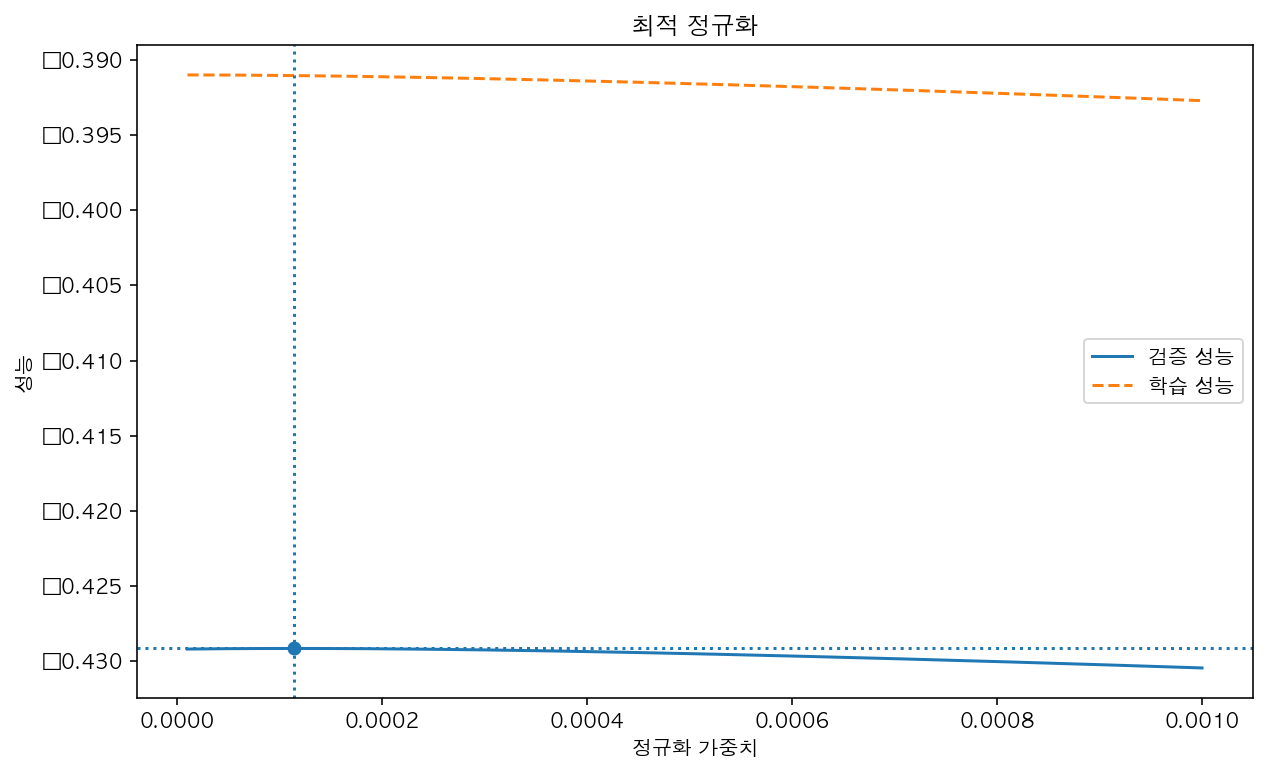

In [2483]:
# Ridge 최적 하이퍼모수 선택

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import cross_val_score

alphas = np.logspace(-5, -3, 200)

train_scores = []
test_scores = []
for alpha in alphas:
    
    test_score_cv = []
    train_score_cv = []
    cv = KFold(5, shuffle=True, random_state=0)
    for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
        df_train = df10.iloc[idx_train]
        df_test = df10.iloc[idx_test]

        model = sm.OLS.from_formula(
            "log_aud ~" + "+".join(feature_names), data=df_train)
        result10_ridge = model.fit_regularized(alpha=alpha, L1_wt=0, refit=False)

        each_train_score = -mean_squared_error(df_train['log_aud'], result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        train_score_cv.append(each_train_score)
        
        each_test_score = -mean_squared_error(df_test['log_aud'], result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        test_score_cv.append(each_test_score)
    
    test_score = np.mean(test_score_cv)
    train_score = np.mean(train_score_cv)
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [2484]:
optimal_alpha

0.00011357333583431052

In [2443]:
# kfold 10 - Ridge

from sklearn.model_selection import KFold

kfold_dict_learn['11'] = []
kfold_dict['11'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result10_ridge = model.fit_regularized(alpha=optimal_alpha, L1_wt=0, refit=False)

    pred = result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    
    # train rsquare구하기
    pred = result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_train['log_aud'] - pred) ** 2).sum()
    tss = ((df_train['log_aud'] - df_train['log_aud'].mean()) ** 2).sum()
    train_rsquared = 1 - rss/tss
    
    kfold_dict_learn['11'].append(train_rsquared)
    kfold_dict['11'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(train_rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['11'])/10)

학습 R2 = -63.62229802, 검증 R2 = -58.86579195
학습 R2 = -62.70593833, 검증 R2 = -65.47913477
학습 R2 = -63.73837080, 검증 R2 = -57.07327124
학습 R2 = -63.00882463, 검증 R2 = -64.41625249
학습 R2 = -63.11321514, 검증 R2 = -63.87316127
학습 R2 = -62.34823735, 검증 R2 = -69.56161686
학습 R2 = -63.78858161, 검증 R2 = -56.78654378
학습 R2 = -61.99711012, 검증 R2 = -73.83469504
학습 R2 = -62.26756050, 검증 R2 = -71.65832727
학습 R2 = -63.54652240, 검증 R2 = -58.39774584


In [2428]:
# model10 - Ridge의 테스트 R2

result10_ridge = model10.fit_regularized(alpha=optimal_alpha, L1_wt=0, refit=False)
pred = result10_ridge.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

-60.33892828619547

In [2429]:
test_rsquare_dict['11'] = rsquared

## Lasso

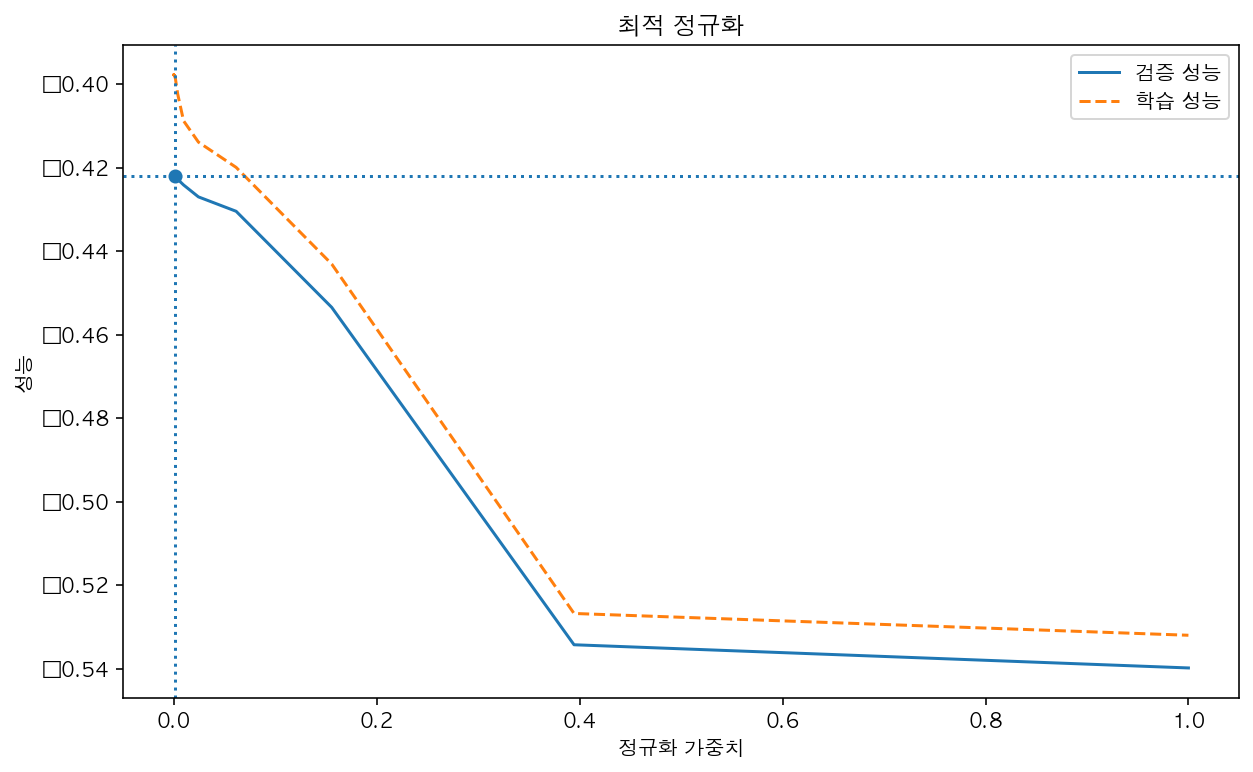

In [2430]:
# Lasso 최적 하이퍼모수 선택

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

alphas = np.logspace(-40, 0, 100)
X = df10_2[['screen_sqrt', 'expert_rating', 'actor_power', 'director_power', 'before_news_log',
           'rating_audiences_log', 'genre_dummy_SF', 'genre_dummy_공포', 'genre_dummy_다큐멘터리',
       'genre_dummy_드라마', 'genre_dummy_멜로/로맨스', 'genre_dummy_미스터리',
       'genre_dummy_범죄', 'genre_dummy_사극', 'genre_dummy_스릴러',
       'genre_dummy_애니메이션', 'genre_dummy_액션', 'genre_dummy_어드벤처',
       'genre_dummy_코미디', 'genre_dummy_판타지', 'sequel_dummy_0',
       'sequel_dummy_1', 'dist_cat_dummy_A', 'dist_cat_dummy_B', 'dist_cat_dummy_C']]
y = df10_2['log_aud']

train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(
        model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [2431]:
optimal_alpha

0.0014849682622544574

In [2432]:
# kfold 10 - Lasso

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold_dict_learn['12'] = []
kfold_dict['12'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result10_lasso = model.fit_regularized(alpha=optimal_alpha, L1_wt=1, refit=False)

    pred = result10_lasso.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    # train rsquare구하기
    pred = result10_lasso.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_train['log_aud'] - pred) ** 2).sum()
    tss = ((df_train['log_aud'] - df_train['log_aud'].mean()) ** 2).sum()
    train_rsquared = 1 - rss/tss
    
    kfold_dict_learn['12'].append(train_rsquared)
    kfold_dict['12'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(train_rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['12'])/10)

학습 R2 = 0.82555410, 검증 R2 = 0.78410203
학습 R2 = 0.81982391, 검증 R2 = 0.84850452
학습 R2 = 0.81700822, 검증 R2 = 0.84329807
학습 R2 = 0.82457626, 검증 R2 = 0.79178427
학습 R2 = 0.82370027, 검증 R2 = 0.79914187
학습 R2 = 0.82377825, 검증 R2 = 0.80010730
학습 R2 = 0.81942554, 검증 R2 = 0.84047241
학습 R2 = 0.82510687, 검증 R2 = 0.79532592
학습 R2 = 0.83219041, 검증 R2 = 0.71201291
학습 R2 = 0.81776425, 검증 R2 = 0.85367141


In [2398]:
# model12 - Lasso의 테스트 R2

result10_lasso = model.fit_regularized(alpha=optimal_alpha, L1_wt=1, refit=False)
pred = result10_lasso.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7948909145502758

In [2399]:
test_rsquare_dict['12'] = rsquared

## ElasticNet

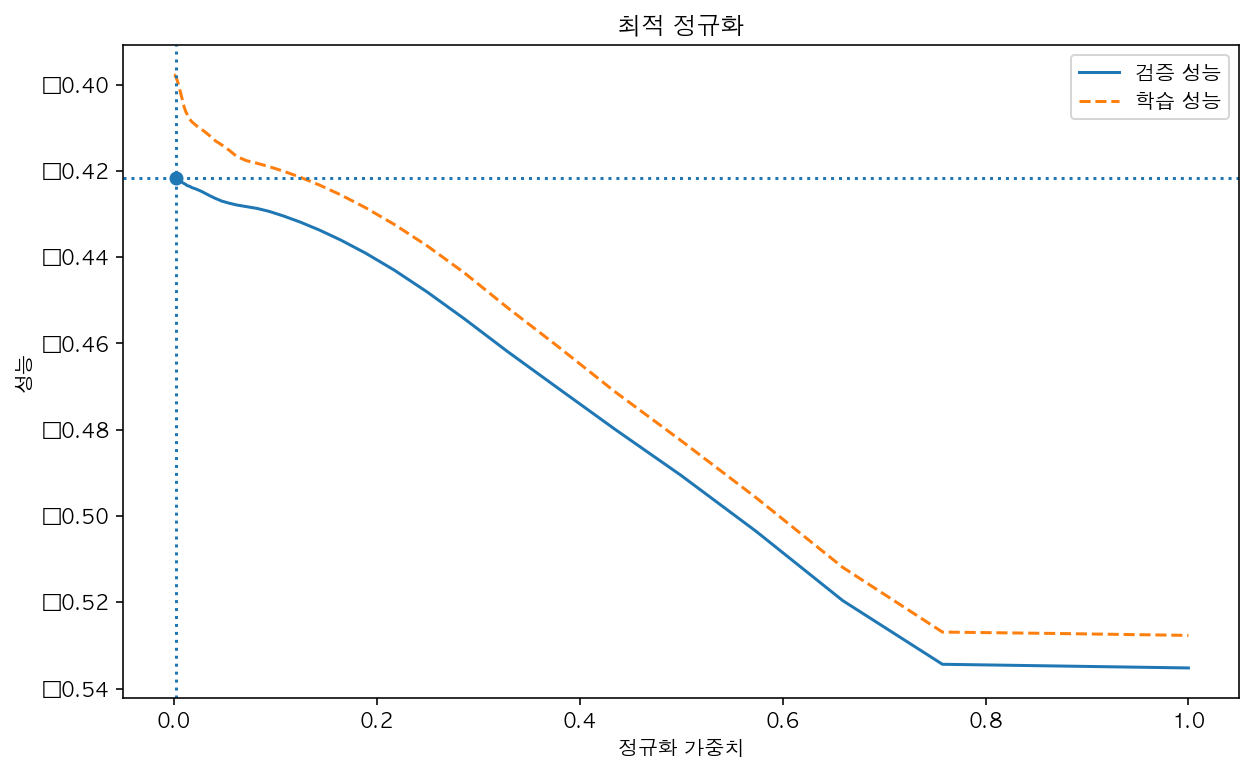

In [2403]:
# ElasticNet 최적 하이퍼모수 선택

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

alphas = np.logspace(-12, 0, 200)
X = df10_2[['screen_sqrt', 'expert_rating', 'actor_power', 'director_power', 'before_news_log',
           'rating_audiences_log', 'genre_dummy_SF', 'genre_dummy_공포', 'genre_dummy_다큐멘터리',
       'genre_dummy_드라마', 'genre_dummy_멜로/로맨스', 'genre_dummy_미스터리',
       'genre_dummy_범죄', 'genre_dummy_사극', 'genre_dummy_스릴러',
       'genre_dummy_애니메이션', 'genre_dummy_액션', 'genre_dummy_어드벤처',
       'genre_dummy_코미디', 'genre_dummy_판타지', 'sequel_dummy_0',
       'sequel_dummy_1', 'dist_cat_dummy_A', 'dist_cat_dummy_B', 'dist_cat_dummy_C']]
y = df10_2['log_aud']

train_scores = []
test_scores = []
for alpha in alphas:
    model = ElasticNet(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(
        model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [2404]:
optimal_alpha

0.0025529080682395165

In [2405]:
# kfold 10 - ElasticNet

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold_dict_learn['13'] = []
kfold_dict['13'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result10_elasticnet = model.fit_regularized(alpha=optimal_alpha, L1_wt=0.5, refit=False)

    pred = result10_elasticnet.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    # train rsquare구하기
    pred = result10_elasticnet.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_train['log_aud'] - pred) ** 2).sum()
    tss = ((df_train['log_aud'] - df_train['log_aud'].mean()) ** 2).sum()
    train_rsquared = 1 - rss/tss
    
    kfold_dict_learn['13'].append(train_rsquared)
    kfold_dict['13'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(train_rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['13'])/10)

학습 R2 = 0.82534003, 검증 R2 = 0.78631602
학습 R2 = 0.81971885, 검증 R2 = 0.84805111
학습 R2 = 0.81738789, 검증 R2 = 0.84062634
학습 R2 = 0.82381623, 검증 R2 = 0.79093111
학습 R2 = 0.82451276, 검증 R2 = 0.79905201
학습 R2 = 0.82337066, 검증 R2 = 0.79517603
학습 R2 = 0.81864254, 검증 R2 = 0.83742197
학습 R2 = 0.82496612, 검증 R2 = 0.80108763
학습 R2 = 0.83216189, 검증 R2 = 0.70812285
학습 R2 = 0.81764781, 검증 R2 = 0.85593055


In [2406]:
# model12 - Lasso의 테스트 R2

result10_elasticnet = model.fit_regularized(alpha=optimal_alpha, L1_wt=0.5, refit=False)
pred = result10_elasticnet.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7946579961942952

In [2407]:
test_rsquare_dict['13'] = rsquared

In [2417]:
test_rsquare_dict

{'1': 0.6063840307534749,
 '2': 0.6243355959961607,
 '3': 0.6445087799148355,
 '4': 0.7048007034475638,
 '5': 0.6990985325678982,
 '6': 0.7439545187829599,
 '7': 0.793510820664285,
 '8': 0.803535812823789,
 '9': 0.8002135828485589,
 '10': 0.8005606168285515,
 '11': 0.803294789679639,
 '12': 0.7948909145502758,
 '13': 0.7946579961942952}

In [2416]:
for key, value in test_rsquare_dict.items():
    model_name_arr.append('model' + str(key))   
result_df_reg = pd.DataFrame(columns=['model'])
result_df_reg['model'] = model_name_arr

test_rsquare_reg_arr = []
for key, value in test_rsquare_dict.items():
    test_rsquare_reg_arr.append(value)
result_df_reg['test_rsquare'] = test_rsquare_reg_arr 

ValueError: Length of values does not match length of index

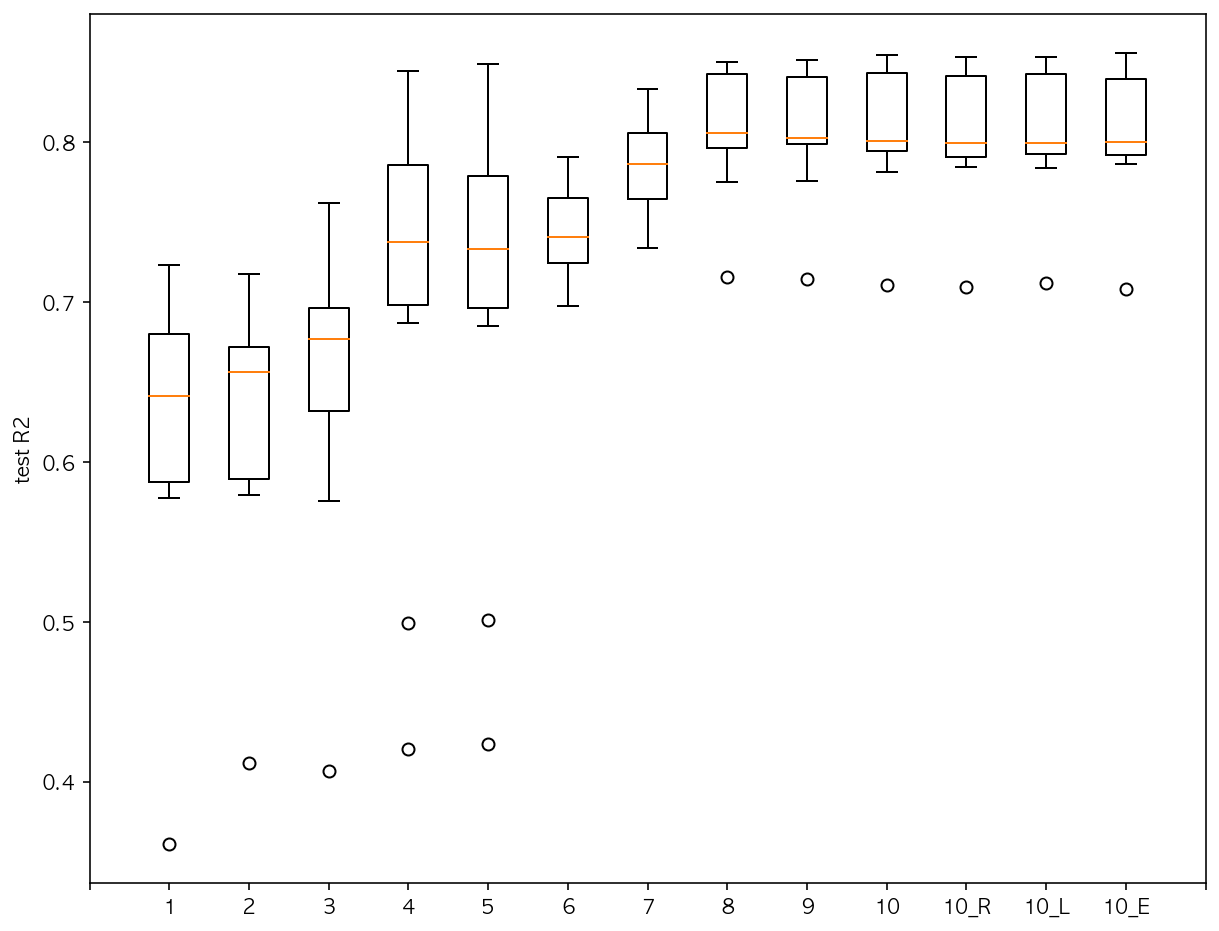

In [2412]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(10, 8))
plt.boxplot((kfold_df['1'], kfold_df['2'], kfold_df['3'], kfold_df['4'], kfold_df['5'], kfold_df['6'], kfold_df['7'],
             kfold_df['8'], kfold_df['9'], kfold_df['10'], kfold_df['11'], kfold_df['12'], kfold_df['13']))
plt.ylabel("test R2")
plt.xticks(np.arange(15), ('', '1', '2', '3', '4', '5', '6',
                           '7', '8', '9', '10', '10_R', '10_L', '10_E'))

plt.show()